In [3]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SolveLinSys
from numba import njit

Let $\tilde{V} = 1000 V$. The PDE is:

\begin{align*}
0 = \max_{\tilde{e}} & b \delta \eta \log \tilde{e} + b(\eta-1)\left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right] \tilde{e}  \theta\\
& + \frac{1}{1000}\frac{\partial \tilde{V}}{\partial y}\tilde{e} \theta  - b \delta \frac{1}{1000} \frac{\partial \tilde{V}}{\partial b}\\
& + \frac{1}{2} \frac{1}{1000} \frac{\partial^2 \tilde{V}}{(\partial y)^2}|\sigma_y|^2(\tilde{e})^2 - \ell \tilde{e}\\
& + b(\eta-1)\left[\frac{1}{2}\left(\gamma_2 + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}\right)\right]|\sigma_y|^2(\tilde{e})^2\\
\end{align*}

The FOC of $\tilde{e}$ gives:

$$
\tilde{e}^* = \frac{-\left[\theta G(y) - \ell\right] - \sqrt{\left[ \theta G(y) - \ell\right]^2-4b\delta \eta |\sigma_y|^2F(y)}}{2|\sigma_y|^2F(y)}
$$

where $G(y):=\frac{1}{1000}\frac{\partial \tilde{V}}{\partial y} + b(\eta-1)\left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right]$, $F(y):=\frac{1}{1000}\frac{\partial^2 V}{(\partial y)^2} + b(\eta-1)\left(\gamma_2 + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}\right)$.


In [4]:
@njit
def compute_derivatives(data, dim, order, dlt):
    res = np.zeros_like(data)
    if order == 1:                    # first order derivatives
        if dim == 0:                  # to first dimension
            res[1:-1,:] = (1 / (2 * dlt)) * (data[2:,:] - data[:-2,:])
            res[-1,:] = (1 / dlt) * (data[-1,:] - data[-2,:])
            res[0,:] = (1 / dlt) * (data[1,:] - data[0,:])
        elif dim == 1:                # to second dimension
            res[:,1:-1] = (1 / (2 * dlt)) * (data[:,2:] - data[:,:-2])
            res[:,-1] = (1 / dlt) * (data[:,-1] - data[:,-2])
            res[:,0] = (1 / dlt) * (data[:,1] - data[:,0])        
    elif order == 2:
        if dim == 0:                  # to first dimension
            res[1:-1,:] = (1 / dlt ** 2) * (data[2:,:] + data[:-2,:] - 2 * data[1:-1,:])
            res[-1,:] = (1 / dlt ** 2) * (data[-1,:] + data[-3,:] - 2 * data[-2,:])
            res[0,:] = (1 / dlt ** 2) * (data[2,:] + data[0,:] - 2 * data[1,:])
        elif dim == 1:                # to second dimension
            res[:,1:-1] = (1 / dlt ** 2) * (data[:,2:] + data[:,:-2] - 2 * data[:,1:-1])
            res[:,-1] = (1 / dlt ** 2) * (data[:,-1] + data[:,-3] - 2 * data[:,-2])
            res[:,0] = (1 / dlt ** 2) * (data[:,2] + data[:,0] - 2 * data[:,1])    
    return res

def false_transient_one_iteration(stateSpace, A, B_y, B_b, C_yy, C_bb, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_y.reshape(-1, 1, order='F'), B_b.reshape(-1, 1, order='F')])
    C = np.hstack([C_yy.reshape(-1, 1, order='F'), C_bb.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out

In [17]:
def false_transient(y_grid, b_grid, ell, multiplier, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000, print_all=True):
    η, δ, θ, πc_o, σ_y, γ_1, γ_2, γ_2p, y_bar = model_paras
    Δ_y = y_grid[1] - y_grid[0]
    Δ_b = b_grid[1] - b_grid[0]
    (y_mat, b_mat) = np.meshgrid(y_grid, b_grid, indexing = 'ij')
    stateSpace = np.hstack([y_mat.reshape(-1, 1, order='F'), b_mat.reshape(-1, 1, order='F')])    

    if v0 is None:
        v0 = -δ*η*(y_mat+y_mat**2)

    d_Λ = γ_1 + γ_2*y_mat + γ_2p*(y_mat>y_bar)*(y_mat-y_bar)
    dd_Λ = γ_2 + γ_2p*(y_mat>y_bar)

    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()

        v0_dy = compute_derivatives(v0, 0, 1, Δ_y)
        v0_dyy = compute_derivatives(v0, 0, 2, Δ_y)
        v0_db = compute_derivatives(v0, 1, 1, Δ_b)

        G = v0_dy/multiplier + b_mat*(η-1)*d_Λ
        F = v0_dyy/multiplier + b_mat*(η-1.)*dd_Λ

        if σ_y == 0:
            e_tilde = -b_mat*δ*η/(G*θ-ell)
        else:
            root = (θ*G - ell)**2 - 4*b_mat*δ*η*(σ_y**2*F)
            root[root<0] = 0.
            e_tilde = (-(G*θ-ell) - np.sqrt(root)) / (2*σ_y**2*F)
        e_tilde[e_tilde<=0] = 1e-16

        A = np.zeros_like(y_mat)
        B_y = e_tilde * θ / multiplier
        B_b = -b_mat*δ / multiplier
        C_yy = .5 * σ_y**2 * e_tilde**2 / multiplier
        C_bb = np.zeros_like(y_mat)
        D = b_mat*δ*η*np.log(e_tilde) + b_mat*(η-1)*d_Λ*e_tilde*θ\
            + .5*b_mat*(η-1)*dd_Λ*σ_y**2*e_tilde**2 - ell*e_tilde
        res = false_transient_one_iteration(stateSpace, A, B_y, B_b, C_yy, C_bb, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_y*v0_dy + B_b*v0_db + C_yy*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,}
    return res

In [40]:
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
# γ_2p = .0197*2*.5 # weighted model of low and high
γ_2p = 0. # low damage model

n_y = 100
y_min = 0.
y_max = 4.
y_grid = np.linspace(y_min, y_max, n_y)

n_b = 100
b_min = 1./n_b
b_max = 1.
b_grid = np.linspace(b_min, b_max, n_b)

model_paras = (η, δ, np.mean(θ), πc_o, σ_y, γ_1, γ_2, γ_2p, y_bar) 

ell = 1e-3
ell_step = ell/100.

model_res = false_transient(y_grid, b_grid, ell, multiplier=10., model_paras=model_paras, v0=None, ϵ=10.,
                            tol=1e-6, max_iter=10_000, print_all=True)
# model_res_right = false_transient(y_grid, b_grid, ell+ell_step, multiplier=10., model_paras=model_paras, v0=None, ϵ=1.,
#                             tol=1e-6, max_iter=10_000, print_all=True)

Iteration 1: LHS Error: 0.0006910244813821919; RHS Error 0.0006948775349430947
Iteration 2: LHS Error: 0.0006871803115050153; RHS Error 0.00069102448140665
Iteration 3: LHS Error: 0.0006833452111875294; RHS Error 0.0006871803115268623
Iteration 4: LHS Error: 0.0006795193619890648; RHS Error 0.0006833452112092896
Iteration 5: LHS Error: 0.0006757029410918095; RHS Error 0.0006795193620107329
Iteration 6: LHS Error: 0.000671896121980125; RHS Error 0.0006757029411970902
Iteration 7: LHS Error: 0.0006680990737129751; RHS Error 0.0006718961220848252
Iteration 8: LHS Error: 0.0006643119614051209; RHS Error 0.0006680990738170973
Iteration 9: LHS Error: 0.0006605349457283062; RHS Error 0.0006643119615086553
Iteration 10: LHS Error: 0.0006567681846705073; RHS Error 0.000660534946088952
Iteration 11: LHS Error: 0.0006530118313799335; RHS Error 0.000656768185028858
Iteration 12: LHS Error: 0.000649266035458454; RHS Error 0.0006530118317360123
Iteration 13: LHS Error: 0.0006455309427646938; RHS Err

Iteration 144: LHS Error: 0.0002716668217444207; RHS Error 0.0002736419762927045
Iteration 145: LHS Error: 0.00026970385167268685; RHS Error 0.00027166682568254783
Iteration 146: LHS Error: 0.00026775301340873357; RHS Error 0.0002697038555811223
Iteration 147: LHS Error: 0.00026581425804157456; RHS Error 0.00026775301728768395
Iteration 148: LHS Error: 0.0002638875364587401; RHS Error 0.00026581426189122286
Iteration 149: LHS Error: 0.00026197279935422644; RHS Error 0.00026388754027921994
Iteration 150: LHS Error: 0.0002600699972373888; RHS Error 0.00026197280314582374
Iteration 151: LHS Error: 0.0002581790804403683; RHS Error 0.00026007000100019157
Iteration 152: LHS Error: 0.0002562999991267412; RHS Error 0.0002581790841747158
Iteration 153: LHS Error: 0.0002544327032987459; RHS Error 0.0002563000028326715
Iteration 154: LHS Error: 0.00025257714280563226; RHS Error 0.0002544327069766171
Iteration 155: LHS Error: 0.0002507332673509888; RHS Error 0.00025257714645558234
Iteration 156: L

Iteration 291: LHS Error: 8.728708782498317e-05; RHS Error 8.874588577781415e-05
Iteration 292: LHS Error: 8.657988708491438e-05; RHS Error 8.804034161751537e-05
Iteration 293: LHS Error: 8.587801519471805e-05; RHS Error 8.734010310343821e-05
Iteration 294: LHS Error: 8.518143795211985e-05; RHS Error 8.664513635356016e-05
Iteration 295: LHS Error: 8.449012136232392e-05; RHS Error 8.59554076879115e-05
Iteration 296: LHS Error: 8.380403163708028e-05; RHS Error 8.527088362782068e-05
Iteration 297: LHS Error: 8.312313519385218e-05; RHS Error 8.459153089495275e-05
Iteration 298: LHS Error: 8.244739865476136e-05; RHS Error 8.391731641071716e-05
Iteration 299: LHS Error: 8.177678884579986e-05; RHS Error 8.324820729528257e-05
Iteration 300: LHS Error: 8.111127279564201e-05; RHS Error 8.258417086674677e-05
Iteration 301: LHS Error: 8.045081773500051e-05; RHS Error 8.192517464027007e-05
Iteration 302: LHS Error: 7.979539109519429e-05; RHS Error 8.127118632714496e-05
Iteration 303: LHS Error: 7.9

Iteration 395: LHS Error: 3.689166208129535e-05; RHS Error 3.8439817700456204e-05
Iteration 396: LHS Error: 3.658742515018076e-05; RHS Error 3.813592482038858e-05
Iteration 397: LHS Error: 3.628583617300007e-05; RHS Error 3.7834674290250525e-05
Iteration 398: LHS Error: 3.598687571634285e-05; RHS Error 3.7536046761838665e-05
Iteration 399: LHS Error: 3.569052443944676e-05; RHS Error 3.724002297902701e-05
Iteration 400: LHS Error: 3.5396763094730496e-05; RHS Error 3.694658377749547e-05
Iteration 401: LHS Error: 3.510557252728308e-05; RHS Error 3.665571008467836e-05
Iteration 402: LHS Error: 3.481693367481942e-05; RHS Error 3.636738291966021e-05
Iteration 403: LHS Error: 3.453082756745829e-05; RHS Error 3.608158339300381e-05
Iteration 404: LHS Error: 3.4247235327922174e-05; RHS Error 3.5798292706664e-05
Iteration 405: LHS Error: 3.396613817110428e-05; RHS Error 3.551749215405253e-05
Iteration 406: LHS Error: 3.3687517404290546e-05; RHS Error 3.523916311979616e-05
Iteration 407: LHS Error

Iteration 500: LHS Error: 1.620074864377985e-05; RHS Error 1.776620488813435e-05
Iteration 501: LHS Error: 1.6085615401728592e-05; RHS Error 1.7651134509708098e-05
Iteration 502: LHS Error: 1.5971586784047086e-05; RHS Error 1.7537167829562075e-05
Iteration 503: LHS Error: 1.585865272688558e-05; RHS Error 1.7424294799910436e-05
Iteration 504: LHS Error: 1.5746803245531017e-05; RHS Error 1.7312505451711315e-05
Iteration 505: LHS Error: 1.5636028433818618e-05; RHS Error 1.72017898943846e-05
Iteration 506: LHS Error: 1.552631846427621e-05; RHS Error 1.7092138315442885e-05
Iteration 507: LHS Error: 1.541766358731378e-05; RHS Error 1.6983540980245663e-05
Iteration 508: LHS Error: 1.531005413113462e-05; RHS Error 1.6875988231630822e-05
Iteration 509: LHS Error: 1.5203480501269073e-05; RHS Error 1.6769470489554246e-05
Iteration 510: LHS Error: 1.5097933180663325e-05; RHS Error 1.6663978250735395e-05
Iteration 511: LHS Error: 1.4993402728602501e-05; RHS Error 1.6559502088441653e-05
Iteration 51

Iteration 608: LHS Error: 8.476018517489247e-06; RHS Error 1.0044096319256784e-05
Iteration 609: LHS Error: 8.436090338748149e-06; RHS Error 1.0004173099182972e-05
Iteration 610: LHS Error: 8.396555550538309e-06; RHS Error 9.96464320575396e-06
Iteration 611: LHS Error: 8.357410307646696e-06; RHS Error 9.925502795372974e-06
Iteration 612: LHS Error: 8.318650800853699e-06; RHS Error 9.886748060049418e-06
Iteration 613: LHS Error: 8.280273256588977e-06; RHS Error 9.848375227421093e-06
Iteration 614: LHS Error: 8.24227393706467e-06; RHS Error 9.810380560714197e-06
Iteration 615: LHS Error: 8.204649140186592e-06; RHS Error 9.772760358681088e-06
Iteration 616: LHS Error: 8.167395199021322e-06; RHS Error 9.735510955415539e-06
Iteration 617: LHS Error: 8.130508482551146e-06; RHS Error 9.69862872045855e-06
Iteration 618: LHS Error: 8.093985394530545e-06; RHS Error 9.662110058223945e-06
Iteration 619: LHS Error: 8.05782237374153e-06; RHS Error 9.625951408160673e-06
Iteration 620: LHS Error: 8.02

Iteration 718: LHS Error: 5.78937219841702e-06; RHS Error 7.357752995001575e-06
Iteration 719: LHS Error: 5.7759764330311825e-06; RHS Error 7.344358616025171e-06
Iteration 720: LHS Error: 5.762713213086634e-06; RHS Error 7.331096768039614e-06
Iteration 721: LHS Error: 5.7495812279873e-06; RHS Error 7.3179661408231175e-06
Iteration 722: LHS Error: 5.736579180504187e-06; RHS Error 7.304965437200097e-06
Iteration 723: LHS Error: 5.723705785931621e-06; RHS Error 7.292093372674498e-06
Iteration 724: LHS Error: 5.71095977242031e-06; RHS Error 7.279348675537671e-06
Iteration 725: LHS Error: 5.698339880533254e-06; RHS Error 7.266730086548856e-06
Iteration 726: LHS Error: 5.685844863312362e-06; RHS Error 7.254236358844764e-06
Iteration 727: LHS Error: 5.673473486145219e-06; RHS Error 7.241866257976979e-06
Iteration 728: LHS Error: 5.661224526631869e-06; RHS Error 7.229618561619658e-06
Iteration 729: LHS Error: 5.649096774207329e-06; RHS Error 7.217492059464581e-06
Iteration 730: LHS Error: 5.63

Iteration 827: LHS Error: 4.893604700728638e-06; RHS Error 6.462076773391728e-06
Iteration 828: LHS Error: 4.889075079028693e-06; RHS Error 6.457547607914278e-06
Iteration 829: LHS Error: 4.8845903016569995e-06; RHS Error 6.453063282237754e-06
Iteration 830: LHS Error: 4.880149924479938e-06; RHS Error 6.448623352401533e-06
Iteration 831: LHS Error: 4.875753508071234e-06; RHS Error 6.444227378896942e-06
Iteration 832: LHS Error: 4.871400617223465e-06; RHS Error 6.4398749264944375e-06
Iteration 833: LHS Error: 4.86709082074821e-06; RHS Error 6.435565564233197e-06
Iteration 834: LHS Error: 4.8628236921643975e-06; RHS Error 6.431298865533985e-06
Iteration 835: LHS Error: 4.858598808987758e-06; RHS Error 6.427074407989466e-06
Iteration 836: LHS Error: 4.854415752886254e-06; RHS Error 6.422891773353798e-06
Iteration 837: LHS Error: 4.850274109724495e-06; RHS Error 6.418750547529297e-06
Iteration 838: LHS Error: 4.8461734695193215e-06; RHS Error 6.4146503205802065e-06
Iteration 839: LHS Error

Iteration 934: LHS Error: 4.593861916779573e-06; RHS Error 6.162364181698998e-06
Iteration 935: LHS Error: 4.592299821037926e-06; RHS Error 6.160802242873215e-06
Iteration 936: LHS Error: 4.590753191369146e-06; RHS Error 6.159255768480878e-06
Iteration 937: LHS Error: 4.589221874362614e-06; RHS Error 6.157724605409111e-06
Iteration 938: LHS Error: 4.587705718894774e-06; RHS Error 6.1562086021542135e-06
Iteration 939: LHS Error: 4.586204574485997e-06; RHS Error 6.154707608542367e-06
Iteration 940: LHS Error: 4.584718292766077e-06; RHS Error 6.153221476065196e-06
Iteration 941: LHS Error: 4.583246726452828e-06; RHS Error 6.151750057532498e-06
Iteration 942: LHS Error: 4.581789729973806e-06; RHS Error 6.150293207338739e-06
Iteration 943: LHS Error: 4.580347158888998e-06; RHS Error 6.148850781206752e-06
Iteration 944: LHS Error: 4.578918870734583e-06; RHS Error 6.147422636428534e-06
Iteration 945: LHS Error: 4.577504723868309e-06; RHS Error 6.146008631543456e-06
Iteration 946: LHS Error: 4

Iteration 1043: LHS Error: 4.4894241214121776e-06; RHS Error 6.057936859255497e-06
Iteration 1044: LHS Error: 4.4888960812672355e-06; RHS Error 6.057408872054445e-06
Iteration 1045: LHS Error: 4.488373269606605e-06; RHS Error 6.05688611273413e-06
Iteration 1046: LHS Error: 4.487855634516258e-06; RHS Error 6.056368529482156e-06
Iteration 1047: LHS Error: 4.487343124703891e-06; RHS Error 6.0558560710225915e-06
Iteration 1048: LHS Error: 4.486835689543334e-06; RHS Error 6.0553486866861145e-06
Iteration 1049: LHS Error: 4.486333278763688e-06; RHS Error 6.054846326114679e-06
Iteration 1050: LHS Error: 4.485835842427122e-06; RHS Error 6.0543489396361035e-06
Iteration 1051: LHS Error: 4.485343331461778e-06; RHS Error 6.053856478045391e-06
Iteration 1052: LHS Error: 4.484855697128865e-06; RHS Error 6.0533688925612505e-06
Iteration 1053: LHS Error: 4.484372891089272e-06; RHS Error 6.052886134833794e-06
Iteration 1054: LHS Error: 4.48389486540357e-06; RHS Error 6.052408157065101e-06
Iteration 10

Iteration 1153: LHS Error: 4.453942757653984e-06; RHS Error 6.022459048610489e-06
Iteration 1154: LHS Error: 4.453766034195894e-06; RHS Error 6.022282342897601e-06
Iteration 1155: LHS Error: 4.453591060560313e-06; RHS Error 6.022107386811633e-06
Iteration 1156: LHS Error: 4.453417819516581e-06; RHS Error 6.02193416305533e-06
Iteration 1157: LHS Error: 4.453246293700808e-06; RHS Error 6.021762654403865e-06
Iteration 1158: LHS Error: 4.4530764662154e-06; RHS Error 6.021592843963959e-06
Iteration 1159: LHS Error: 4.452908320340399e-06; RHS Error 6.021424714952811e-06
Iteration 1160: LHS Error: 4.452741839355845e-06; RHS Error 6.021258250572229e-06
Iteration 1161: LHS Error: 4.452577006675007e-06; RHS Error 6.021093434440349e-06
Iteration 1162: LHS Error: 4.452413806155242e-06; RHS Error 6.020930250251748e-06
Iteration 1163: LHS Error: 4.452252221476271e-06; RHS Error 6.020768681774401e-06
Iteration 1164: LHS Error: 4.452092236739702e-06; RHS Error 6.0206087130603445e-06
Iteration 1165: LH

Iteration 1263: LHS Error: 4.442067896204271e-06; RHS Error 6.010585376481749e-06
Iteration 1264: LHS Error: 4.442008750404902e-06; RHS Error 6.010526236576862e-06
Iteration 1265: LHS Error: 4.441950190225974e-06; RHS Error 6.010467682204248e-06
Iteration 1266: LHS Error: 4.441892209672282e-06; RHS Error 6.01040970757351e-06
Iteration 1267: LHS Error: 4.441834803525779e-06; RHS Error 6.010352307064468e-06
Iteration 1268: LHS Error: 4.4417779655692154e-06; RHS Error 6.010295474822322e-06
Iteration 1269: LHS Error: 4.441721690429113e-06; RHS Error 6.010239205347565e-06
Iteration 1270: LHS Error: 4.441665972509945e-06; RHS Error 6.010183493004406e-06
Iteration 1271: LHS Error: 4.441610806282803e-06; RHS Error 6.010128332296916e-06
Iteration 1272: LHS Error: 4.441556186196571e-06; RHS Error 6.010073717718756e-06
Iteration 1273: LHS Error: 4.441502107055406e-06; RHS Error 6.010019643915921e-06
Iteration 1274: LHS Error: 4.441448563219374e-06; RHS Error 6.009966105493419e-06
Iteration 1275: 

Iteration 1370: LHS Error: 4.438154186159338e-06; RHS Error 6.006672058198395e-06
Iteration 1371: LHS Error: 4.43813379118474e-06; RHS Error 6.00665166536373e-06
Iteration 1372: LHS Error: 4.438113598248527e-06; RHS Error 6.006631474448493e-06
Iteration 1373: LHS Error: 4.438093605307891e-06; RHS Error 6.006611483450053e-06
Iteration 1374: LHS Error: 4.438073810208998e-06; RHS Error 6.006591690347566e-06
Iteration 1375: LHS Error: 4.438054211153286e-06; RHS Error 6.006572093283794e-06
Iteration 1376: LHS Error: 4.438034806164559e-06; RHS Error 6.006552690235724e-06
Iteration 1377: LHS Error: 4.438015593311029e-06; RHS Error 6.00653347930134e-06
Iteration 1378: LHS Error: 4.4379965707275206e-06; RHS Error 6.0065144585925035e-06
Iteration 1379: LHS Error: 4.437977736393428e-06; RHS Error 6.006495626195382e-06
Iteration 1380: LHS Error: 4.437959088643418e-06; RHS Error 6.006476980296104e-06
Iteration 1381: LHS Error: 4.437940625523496e-06; RHS Error 6.006458519003822e-06
Iteration 1382: L

Iteration 1477: LHS Error: 4.43680464508045e-06; RHS Error 6.005322652125511e-06
Iteration 1478: LHS Error: 4.4367976124837226e-06; RHS Error 6.005315620203158e-06
Iteration 1479: LHS Error: 4.436790649520184e-06; RHS Error 6.005308657898727e-06
Iteration 1480: LHS Error: 4.436783755346063e-06; RHS Error 6.005301764499139e-06
Iteration 1481: LHS Error: 4.436776929561681e-06; RHS Error 6.005294939377833e-06
Iteration 1482: LHS Error: 4.4367701713232675e-06; RHS Error 6.00528818183886e-06
Iteration 1483: LHS Error: 4.436763480053507e-06; RHS Error 6.0052814912132674e-06
Iteration 1484: LHS Error: 4.436756854975243e-06; RHS Error 6.005274866810201e-06
Iteration 1485: LHS Error: 4.436750295577774e-06; RHS Error 6.005268307992802e-06
Iteration 1486: LHS Error: 4.436743800995125e-06; RHS Error 6.005261814066528e-06
Iteration 1487: LHS Error: 4.436737370783206e-06; RHS Error 6.0052553845157345e-06
Iteration 1488: LHS Error: 4.436731004209271e-06; RHS Error 6.00524901861433e-06
Iteration 1489:

Iteration 1578: LHS Error: 4.436354358383632e-06; RHS Error 6.00487241017968e-06
Iteration 1579: LHS Error: 4.4363517840873e-06; RHS Error 6.004869836185385e-06
Iteration 1580: LHS Error: 4.436349235303894e-06; RHS Error 6.004867287691417e-06
Iteration 1581: LHS Error: 4.436346711900185e-06; RHS Error 6.004864764499042e-06
Iteration 1582: LHS Error: 4.436344213409882e-06; RHS Error 6.004862266234317e-06
Iteration 1583: LHS Error: 4.436341739610939e-06; RHS Error 6.004859792689402e-06
Iteration 1584: LHS Error: 4.436339290303515e-06; RHS Error 6.004857343653853e-06
Iteration 1585: LHS Error: 4.436336865265566e-06; RHS Error 6.004854918842417e-06
Iteration 1586: LHS Error: 4.436334464252844e-06; RHS Error 6.004852518090619e-06
Iteration 1587: LHS Error: 4.4363320870211e-06; RHS Error 6.004850141059538e-06
Iteration 1588: LHS Error: 4.436329733281674e-06; RHS Error 6.004847787572233e-06
Iteration 1589: LHS Error: 4.4363274028569325e-06; RHS Error 6.004845457395491e-06
Iteration 1590: LHS 

Iteration 1689: LHS Error: 4.436180521993904e-06; RHS Error 6.004698591002638e-06
Iteration 1690: LHS Error: 4.436179669120577e-06; RHS Error 6.004697738060463e-06
Iteration 1691: LHS Error: 4.4361788244184904e-06; RHS Error 6.004696893537227e-06
Iteration 1692: LHS Error: 4.436177988198508e-06; RHS Error 6.004696057400837e-06
Iteration 1693: LHS Error: 4.436177160238586e-06; RHS Error 6.0046952295286695e-06
Iteration 1694: LHS Error: 4.436176340605336e-06; RHS Error 6.00469440991281e-06
Iteration 1695: LHS Error: 4.436175528921282e-06; RHS Error 6.004693598341514e-06
Iteration 1696: LHS Error: 4.436174725386266e-06; RHS Error 6.00469279485945e-06
Iteration 1697: LHS Error: 4.4361739297116285e-06; RHS Error 6.004691999279377e-06
Iteration 1698: LHS Error: 4.436173141919575e-06; RHS Error 6.004691211647373e-06
Iteration 1699: LHS Error: 4.436172362076718e-06; RHS Error 6.004690431796146e-06
Iteration 1700: LHS Error: 4.436171589783378e-06; RHS Error 6.004689659595483e-06
Iteration 1701:

Iteration 1802: LHS Error: 4.436124603579561e-06; RHS Error 6.004640429879476e-06
Iteration 1803: LHS Error: 4.436124600809554e-06; RHS Error 6.004640152797191e-06
Iteration 1804: LHS Error: 4.436124598064528e-06; RHS Error 6.004639878484609e-06
Iteration 1805: LHS Error: 4.436124595345869e-06; RHS Error 6.004639606821058e-06
Iteration 1806: LHS Error: 4.4361245926619055e-06; RHS Error 6.0046393379158255e-06
Iteration 1807: LHS Error: 4.436124589995982e-06; RHS Error 6.004639071682284e-06
Iteration 1808: LHS Error: 4.436124587364754e-06; RHS Error 6.004638808030879e-06
Iteration 1809: LHS Error: 4.436124584750178e-06; RHS Error 6.004638546973752e-06
Iteration 1810: LHS Error: 4.436124582167522e-06; RHS Error 6.004638288543865e-06
Iteration 1811: LHS Error: 4.436124579608458e-06; RHS Error 6.004638032709015e-06
Iteration 1812: LHS Error: 4.436124577074374e-06; RHS Error 6.00463777940144e-06
Iteration 1813: LHS Error: 4.436124574568046e-06; RHS Error 6.004637528532128e-06
Iteration 1814:

Iteration 1910: LHS Error: 4.436124419282539e-06; RHS Error 6.004622000242536e-06
Iteration 1911: LHS Error: 4.436124418334686e-06; RHS Error 6.004621905669532e-06
Iteration 1912: LHS Error: 4.436124417400711e-06; RHS Error 6.00462181200715e-06
Iteration 1913: LHS Error: 4.436124416472287e-06; RHS Error 6.004621719279566e-06
Iteration 1914: LHS Error: 4.436124415550802e-06; RHS Error 6.004621627422814e-06
Iteration 1915: LHS Error: 4.43612441464597e-06; RHS Error 6.004621536531002e-06
Iteration 1916: LHS Error: 4.436124413742526e-06; RHS Error 6.004621446541463e-06
Iteration 1917: LHS Error: 4.4361244128501846e-06; RHS Error 6.004621357451594e-06
Iteration 1918: LHS Error: 4.436124411968945e-06; RHS Error 6.004621269219438e-06
Iteration 1919: LHS Error: 4.436124411096032e-06; RHS Error 6.004621181877738e-06
Iteration 1920: LHS Error: 4.43612441022867e-06; RHS Error 6.004621095382148e-06
Iteration 1921: LHS Error: 4.436124409373799e-06; RHS Error 6.004621009710878e-06
Iteration 1922: LH

Iteration 2013: LHS Error: 4.436124358007942e-06; RHS Error 6.004615874365495e-06
Iteration 2014: LHS Error: 4.4361243576693245e-06; RHS Error 6.004615840419559e-06
Iteration 2015: LHS Error: 4.436124357333482e-06; RHS Error 6.0046158068136285e-06
Iteration 2016: LHS Error: 4.436124356997639e-06; RHS Error 6.004615773538705e-06
Iteration 2017: LHS Error: 4.4361243566728995e-06; RHS Error 6.004615740614412e-06
Iteration 2018: LHS Error: 4.436124356345383e-06; RHS Error 6.004615707987083e-06
Iteration 2019: LHS Error: 4.436124356019255e-06; RHS Error 6.004615675678725e-06
Iteration 2020: LHS Error: 4.436124355702842e-06; RHS Error 6.004615643666789e-06
Iteration 2021: LHS Error: 4.436124355386428e-06; RHS Error 6.0046156120179515e-06
Iteration 2022: LHS Error: 4.436124355070015e-06; RHS Error 6.004615580665535e-06
Iteration 2023: LHS Error: 4.436124354761928e-06; RHS Error 6.004615549610732e-06
Iteration 2024: LHS Error: 4.436124354451065e-06; RHS Error 6.004615518928136e-06
Iteration 20

Iteration 2119: LHS Error: 4.436124335652214e-06; RHS Error 6.004613639853224e-06
Iteration 2120: LHS Error: 4.43612433553009e-06; RHS Error 6.0046136280318425e-06
Iteration 2121: LHS Error: 4.4361243354149035e-06; RHS Error 6.00461361630934e-06
Iteration 2122: LHS Error: 4.436124335299718e-06; RHS Error 6.004613604719436e-06
Iteration 2123: LHS Error: 4.436124335183145e-06; RHS Error 6.004613593250745e-06
Iteration 2124: LHS Error: 4.4361243350707345e-06; RHS Error 6.004613581869875e-06
Iteration 2125: LHS Error: 4.436124334954162e-06; RHS Error 6.004613570631035e-06
Iteration 2126: LHS Error: 4.436124334843139e-06; RHS Error 6.004613559491617e-06
Iteration 2127: LHS Error: 4.43612433473628e-06; RHS Error 6.004613548483929e-06
Iteration 2128: LHS Error: 4.436124334626645e-06; RHS Error 6.004613537552135e-06
Iteration 2129: LHS Error: 4.43612433451146e-06; RHS Error 6.004613526764324e-06
Iteration 2130: LHS Error: 4.436124334410152e-06; RHS Error 6.004613516030939e-06
Iteration 2131: L

Iteration 2225: LHS Error: 4.436124327847346e-06; RHS Error 6.004612861416447e-06
Iteration 2226: LHS Error: 4.436124327808488e-06; RHS Error 6.0046128573225e-06
Iteration 2227: LHS Error: 4.436124327768242e-06; RHS Error 6.004612853215867e-06
Iteration 2228: LHS Error: 4.436124327726609e-06; RHS Error 6.004612849187514e-06
Iteration 2229: LHS Error: 4.436124327683588e-06; RHS Error 6.004612845181929e-06
Iteration 2230: LHS Error: 4.436124327644731e-06; RHS Error 6.004612841219387e-06
Iteration 2231: LHS Error: 4.436124327605873e-06; RHS Error 6.004612837311814e-06
Iteration 2232: LHS Error: 4.436124327565627e-06; RHS Error 6.004612833427443e-06
Iteration 2233: LHS Error: 4.436124327526769e-06; RHS Error 6.004612829597173e-06
Iteration 2234: LHS Error: 4.436124327489299e-06; RHS Error 6.004612825798996e-06
Iteration 2235: LHS Error: 4.436124327454605e-06; RHS Error 6.004612822056764e-06
Iteration 2236: LHS Error: 4.436124327415747e-06; RHS Error 6.0046128183136645e-06
Iteration 2237: L

Iteration 2374: LHS Error: 4.436124324609658e-06; RHS Error 6.004612539555745e-06
Iteration 2375: LHS Error: 4.436124324594393e-06; RHS Error 6.004612538616175e-06
Iteration 2376: LHS Error: 4.436124324586066e-06; RHS Error 6.004612537710216e-06
Iteration 2377: LHS Error: 4.436124324574964e-06; RHS Error 6.004612536802956e-06
Iteration 2378: LHS Error: 4.436124324565249e-06; RHS Error 6.00461253586241e-06
Iteration 2379: LHS Error: 4.43612432455831e-06; RHS Error 6.004612534976942e-06
Iteration 2380: LHS Error: 4.436124324551371e-06; RHS Error 6.0046125340703325e-06
Iteration 2381: LHS Error: 4.436124324540269e-06; RHS Error 6.004612533163506e-06
Iteration 2382: LHS Error: 4.436124324531943e-06; RHS Error 6.004612532311106e-06
Iteration 2383: LHS Error: 4.436124324522228e-06; RHS Error 6.004612531427156e-06
Iteration 2384: LHS Error: 4.436124324513901e-06; RHS Error 6.004612530587225e-06
Iteration 2385: LHS Error: 4.436124324506962e-06; RHS Error 6.004612529779169e-06
Iteration 2386: L

Iteration 2477: LHS Error: 4.436124323980995e-06; RHS Error 6.004612478747507e-06
Iteration 2478: LHS Error: 4.4361243239698925e-06; RHS Error 6.004612478423331e-06
Iteration 2479: LHS Error: 4.4361243239698925e-06; RHS Error 6.004612478086903e-06
Iteration 2480: LHS Error: 4.4361243239698925e-06; RHS Error 6.004612477729767e-06
Iteration 2481: LHS Error: 4.436124323961565e-06; RHS Error 6.004612477350838e-06
Iteration 2482: LHS Error: 4.436124323961565e-06; RHS Error 6.004612477059621e-06
Iteration 2483: LHS Error: 4.436124323953239e-06; RHS Error 6.004612476768513e-06
Iteration 2484: LHS Error: 4.436124323944912e-06; RHS Error 6.00461247645507e-06
Iteration 2485: LHS Error: 4.436124323944912e-06; RHS Error 6.004612476151819e-06
Iteration 2486: LHS Error: 4.4361243239476876e-06; RHS Error 6.004612475816692e-06
Iteration 2487: LHS Error: 4.436124323942137e-06; RHS Error 6.004612475502273e-06
Iteration 2488: LHS Error: 4.436124323939361e-06; RHS Error 6.004612475188288e-06
Iteration 248

Iteration 2582: LHS Error: 4.4361243237422965e-06; RHS Error 6.0046124564088225e-06
Iteration 2583: LHS Error: 4.436124323731194e-06; RHS Error 6.004612456294548e-06
Iteration 2584: LHS Error: 4.436124323736745e-06; RHS Error 6.004612456178321e-06
Iteration 2585: LHS Error: 4.436124323728419e-06; RHS Error 6.004612456073804e-06
Iteration 2586: LHS Error: 4.43612432373397e-06; RHS Error 6.004612455935677e-06
Iteration 2587: LHS Error: 4.436124323728419e-06; RHS Error 6.0046124557980914e-06
Iteration 2588: LHS Error: 4.436124323731194e-06; RHS Error 6.004612455705392e-06
Iteration 2589: LHS Error: 4.436124323731194e-06; RHS Error 6.004612455579516e-06
Iteration 2590: LHS Error: 4.436124323722867e-06; RHS Error 6.004612455475541e-06
Iteration 2591: LHS Error: 4.436124323725643e-06; RHS Error 6.004612455359423e-06
Iteration 2592: LHS Error: 4.436124323722867e-06; RHS Error 6.004612455244823e-06
Iteration 2593: LHS Error: 4.436124323725643e-06; RHS Error 6.004612455117863e-06
Iteration 2594

Iteration 2686: LHS Error: 4.436124323645152e-06; RHS Error 6.004612448400146e-06
Iteration 2687: LHS Error: 4.436124323645152e-06; RHS Error 6.004612448373041e-06
Iteration 2688: LHS Error: 4.4361243236396005e-06; RHS Error 6.0046124483230595e-06
Iteration 2689: LHS Error: 4.4361243236396005e-06; RHS Error 6.004612448283703e-06
Iteration 2690: LHS Error: 4.436124323642376e-06; RHS Error 6.004612448245214e-06
Iteration 2691: LHS Error: 4.436124323642376e-06; RHS Error 6.004612448184824e-06
Iteration 2692: LHS Error: 4.4361243236396005e-06; RHS Error 6.004612448123675e-06
Iteration 2693: LHS Error: 4.436124323642376e-06; RHS Error 6.004612448051684e-06
Iteration 2694: LHS Error: 4.436124323642376e-06; RHS Error 6.004612448045721e-06
Iteration 2695: LHS Error: 4.436124323636826e-06; RHS Error 6.004612447996173e-06
Iteration 2696: LHS Error: 4.43612432363405e-06; RHS Error 6.0046124479569245e-06
Iteration 2697: LHS Error: 4.436124323636826e-06; RHS Error 6.004612447907485e-06
Iteration 26

Iteration 2795: LHS Error: 4.436124323597967e-06; RHS Error 6.004612445255201e-06
Iteration 2796: LHS Error: 4.4361243235924165e-06; RHS Error 6.004612445294124e-06
Iteration 2797: LHS Error: 4.436124323595192e-06; RHS Error 6.004612445265935e-06
Iteration 2798: LHS Error: 4.4361243235924165e-06; RHS Error 6.00461244522712e-06
Iteration 2799: LHS Error: 4.436124323595192e-06; RHS Error 6.004612445210749e-06
Iteration 2800: LHS Error: 4.436124323586865e-06; RHS Error 6.004612445172693e-06
Iteration 2801: LHS Error: 4.436124323586865e-06; RHS Error 6.004612445134204e-06
Iteration 2802: LHS Error: 4.4361243235924165e-06; RHS Error 6.004612445128241e-06
Iteration 2803: LHS Error: 4.436124323586865e-06; RHS Error 6.004612445123037e-06
Iteration 2804: LHS Error: 4.4361243235813145e-06; RHS Error 6.004612445095281e-06
Iteration 2805: LHS Error: 4.4361243235924165e-06; RHS Error 6.0046124451004854e-06
Iteration 2806: LHS Error: 4.436124323589641e-06; RHS Error 6.004612445072513e-06
Iteration 2

Iteration 2902: LHS Error: 4.436124323561885e-06; RHS Error 6.004612443996551e-06
Iteration 2903: LHS Error: 4.436124323561885e-06; RHS Error 6.00461244401444e-06
Iteration 2904: LHS Error: 4.436124323561885e-06; RHS Error 6.0046124439753e-06
Iteration 2905: LHS Error: 4.436124323564661e-06; RHS Error 6.004612443926186e-06
Iteration 2906: LHS Error: 4.436124323564661e-06; RHS Error 6.004612443920657e-06
Iteration 2907: LHS Error: 4.436124323564661e-06; RHS Error 6.004612443927053e-06
Iteration 2908: LHS Error: 4.436124323564661e-06; RHS Error 6.0046124439221745e-06
Iteration 2909: LHS Error: 4.436124323564661e-06; RHS Error 6.0046124439154525e-06
Iteration 2910: LHS Error: 4.436124323561885e-06; RHS Error 6.004612443920765e-06
Iteration 2911: LHS Error: 4.436124323561885e-06; RHS Error 6.0046124439384375e-06
Iteration 2912: LHS Error: 4.436124323556334e-06; RHS Error 6.0046124439214156e-06
Iteration 2913: LHS Error: 4.436124323561885e-06; RHS Error 6.004612443904177e-06
Iteration 2914:

Iteration 3006: LHS Error: 4.436124323542456e-06; RHS Error 6.004612443368364e-06
Iteration 3007: LHS Error: 4.436124323545232e-06; RHS Error 6.004612443351776e-06
Iteration 3008: LHS Error: 4.436124323542456e-06; RHS Error 6.0046124433243454e-06
Iteration 3009: LHS Error: 4.436124323542456e-06; RHS Error 6.004612443362184e-06
Iteration 3010: LHS Error: 4.436124323545232e-06; RHS Error 6.004612443389831e-06
Iteration 3011: LHS Error: 4.436124323545232e-06; RHS Error 6.004612443383109e-06
Iteration 3012: LHS Error: 4.436124323542456e-06; RHS Error 6.004612443344295e-06
Iteration 3013: LHS Error: 4.436124323542456e-06; RHS Error 6.004612443317298e-06
Iteration 3014: LHS Error: 4.436124323539681e-06; RHS Error 6.004612443301577e-06
Iteration 3015: LHS Error: 4.436124323542456e-06; RHS Error 6.004612443318057e-06
Iteration 3016: LHS Error: 4.436124323542456e-06; RHS Error 6.004612443302228e-06
Iteration 3017: LHS Error: 4.436124323545232e-06; RHS Error 6.004612443285748e-06
Iteration 3018:

Iteration 3108: LHS Error: 4.436124323525803e-06; RHS Error 6.004612442955825e-06
Iteration 3109: LHS Error: 4.436124323528578e-06; RHS Error 6.00461244293902e-06
Iteration 3110: LHS Error: 4.436124323523028e-06; RHS Error 6.004612442934466e-06
Iteration 3111: LHS Error: 4.436124323528578e-06; RHS Error 6.004612442950621e-06
Iteration 3112: LHS Error: 4.436124323523028e-06; RHS Error 6.004612442923191e-06
Iteration 3113: LHS Error: 4.436124323523028e-06; RHS Error 6.004612442884376e-06
Iteration 3114: LHS Error: 4.436124323523028e-06; RHS Error 6.0046124428573796e-06
Iteration 3115: LHS Error: 4.436124323523028e-06; RHS Error 6.004612442852284e-06
Iteration 3116: LHS Error: 4.436124323528578e-06; RHS Error 6.0046124428240946e-06
Iteration 3117: LHS Error: 4.436124323528578e-06; RHS Error 6.004612442829624e-06
Iteration 3118: LHS Error: 4.436124323523028e-06; RHS Error 6.0046124428465375e-06
Iteration 3119: LHS Error: 4.436124323528578e-06; RHS Error 6.0046124428409e-06
Iteration 3120: 

Iteration 3214: LHS Error: 4.436124323503598e-06; RHS Error 6.00461244254372e-06
Iteration 3215: LHS Error: 4.436124323503598e-06; RHS Error 6.004612442537865e-06
Iteration 3216: LHS Error: 4.436124323503598e-06; RHS Error 6.0046124425420936e-06
Iteration 3217: LHS Error: 4.436124323506374e-06; RHS Error 6.004612442536889e-06
Iteration 3218: LHS Error: 4.436124323503598e-06; RHS Error 6.004612442509025e-06
Iteration 3219: LHS Error: 4.436124323498048e-06; RHS Error 6.004612442503496e-06
Iteration 3220: LHS Error: 4.436124323500823e-06; RHS Error 6.004612442465332e-06
Iteration 3221: LHS Error: 4.436124323500823e-06; RHS Error 6.004612442471078e-06
Iteration 3222: LHS Error: 4.436124323498048e-06; RHS Error 6.004612442499268e-06
Iteration 3223: LHS Error: 4.436124323506374e-06; RHS Error 6.004612442504363e-06
Iteration 3224: LHS Error: 4.436124323503598e-06; RHS Error 6.004612442520735e-06
Iteration 3225: LHS Error: 4.436124323503598e-06; RHS Error 6.004612442559007e-06
Iteration 3226: 

Iteration 3321: LHS Error: 4.436124323486945e-06; RHS Error 6.004612442196992e-06
Iteration 3322: LHS Error: 4.436124323486945e-06; RHS Error 6.004612442235915e-06
Iteration 3323: LHS Error: 4.43612432348417e-06; RHS Error 6.00461244225272e-06
Iteration 3324: LHS Error: 4.4361243234786185e-06; RHS Error 6.004612442236782e-06
Iteration 3325: LHS Error: 4.43612432348417e-06; RHS Error 6.0046124422309275e-06
Iteration 3326: LHS Error: 4.43612432348417e-06; RHS Error 6.0046124422582494e-06
Iteration 3327: LHS Error: 4.43612432348417e-06; RHS Error 6.004612442208376e-06
Iteration 3328: LHS Error: 4.4361243234897206e-06; RHS Error 6.004612442193089e-06
Iteration 3329: LHS Error: 4.436124323481394e-06; RHS Error 6.004612442198727e-06
Iteration 3330: LHS Error: 4.43612432348417e-06; RHS Error 6.0046124422038225e-06
Iteration 3331: LHS Error: 4.436124323486945e-06; RHS Error 6.004612442176067e-06
Iteration 3332: LHS Error: 4.4361243234786185e-06; RHS Error 6.004612442148962e-06
Iteration 3333: 

Iteration 3424: LHS Error: 4.436124323459189e-06; RHS Error 6.004612441954781e-06
Iteration 3425: LHS Error: 4.436124323459189e-06; RHS Error 6.004612441948493e-06
Iteration 3426: LHS Error: 4.436124323459189e-06; RHS Error 6.004612441921496e-06
Iteration 3427: LHS Error: 4.436124323464741e-06; RHS Error 6.004612441893849e-06
Iteration 3428: LHS Error: 4.436124323461965e-06; RHS Error 6.004612441911413e-06
Iteration 3429: LHS Error: 4.436124323459189e-06; RHS Error 6.004612441927459e-06
Iteration 3430: LHS Error: 4.436124323464741e-06; RHS Error 6.004612441922147e-06
Iteration 3431: LHS Error: 4.436124323461965e-06; RHS Error 6.004612441905125e-06
Iteration 3432: LHS Error: 4.436124323459189e-06; RHS Error 6.004612441921388e-06
Iteration 3433: LHS Error: 4.436124323456414e-06; RHS Error 6.004612441938735e-06
Iteration 3434: LHS Error: 4.436124323461965e-06; RHS Error 6.004612441955323e-06
Iteration 3435: LHS Error: 4.436124323461965e-06; RHS Error 6.00461244193841e-06
Iteration 3436: L

Iteration 3525: LHS Error: 4.436124323439761e-06; RHS Error 6.004612441579864e-06
Iteration 3526: LHS Error: 4.436124323436985e-06; RHS Error 6.004612441564577e-06
Iteration 3527: LHS Error: 4.436124323439761e-06; RHS Error 6.004612441570215e-06
Iteration 3528: LHS Error: 4.436124323439761e-06; RHS Error 6.004612441564577e-06
Iteration 3529: LHS Error: 4.436124323442537e-06; RHS Error 6.004612441592658e-06
Iteration 3530: LHS Error: 4.4361243234453115e-06; RHS Error 6.00461244163093e-06
Iteration 3531: LHS Error: 4.436124323442537e-06; RHS Error 6.004612441614233e-06
Iteration 3532: LHS Error: 4.4361243234453115e-06; RHS Error 6.004612441565444e-06
Iteration 3533: LHS Error: 4.436124323439761e-06; RHS Error 6.0046124415603485e-06
Iteration 3534: LHS Error: 4.436124323442537e-06; RHS Error 6.004612441565444e-06
Iteration 3535: LHS Error: 4.4361243234342094e-06; RHS Error 6.0046124415595896e-06
Iteration 3536: LHS Error: 4.4361243234453115e-06; RHS Error 6.0046124415650106e-06
Iteration 

Iteration 3628: LHS Error: 4.436124323414781e-06; RHS Error 6.004612441338521e-06
Iteration 3629: LHS Error: 4.436124323417556e-06; RHS Error 6.0046124413228e-06
Iteration 3630: LHS Error: 4.436124323417556e-06; RHS Error 6.004612441284419e-06
Iteration 3631: LHS Error: 4.436124323423107e-06; RHS Error 6.004612441277914e-06
Iteration 3632: LHS Error: 4.436124323417556e-06; RHS Error 6.004612441260892e-06
Iteration 3633: LHS Error: 4.436124323420332e-06; RHS Error 6.004612441254929e-06
Iteration 3634: LHS Error: 4.436124323420332e-06; RHS Error 6.004612441249833e-06
Iteration 3635: LHS Error: 4.436124323414781e-06; RHS Error 6.004612441244846e-06
Iteration 3636: LHS Error: 4.436124323414781e-06; RHS Error 6.0046124412613255e-06
Iteration 3637: LHS Error: 4.436124323414781e-06; RHS Error 6.004612441265879e-06
Iteration 3638: LHS Error: 4.436124323417556e-06; RHS Error 6.004612441238666e-06
Iteration 3639: LHS Error: 4.436124323420332e-06; RHS Error 6.004612441232703e-06
Iteration 3640: L

Iteration 3736: LHS Error: 4.436124323403678e-06; RHS Error 6.004612440891721e-06
Iteration 3737: LHS Error: 4.436124323403678e-06; RHS Error 6.004612440908201e-06
Iteration 3738: LHS Error: 4.436124323400903e-06; RHS Error 6.004612440945064e-06
Iteration 3739: LHS Error: 4.4361243233981275e-06; RHS Error 6.004612440939101e-06
Iteration 3740: LHS Error: 4.436124323403678e-06; RHS Error 6.00461244093368e-06
Iteration 3741: LHS Error: 4.436124323400903e-06; RHS Error 6.004612440895407e-06
Iteration 3742: LHS Error: 4.436124323406454e-06; RHS Error 6.00461244091167e-06
Iteration 3743: LHS Error: 4.436124323400903e-06; RHS Error 6.0046124409290176e-06
Iteration 3744: LHS Error: 4.436124323395352e-06; RHS Error 6.0046124409447385e-06
Iteration 3745: LHS Error: 4.436124323403678e-06; RHS Error 6.004612440960026e-06
Iteration 3746: LHS Error: 4.436124323403678e-06; RHS Error 6.004612440943221e-06
Iteration 3747: LHS Error: 4.436124323400903e-06; RHS Error 6.004612440938342e-06
Iteration 3748:

Iteration 3842: LHS Error: 4.4361243233870255e-06; RHS Error 6.004612440628802e-06
Iteration 3843: LHS Error: 4.4361243233759225e-06; RHS Error 6.004612440634548e-06
Iteration 3844: LHS Error: 4.436124323378698e-06; RHS Error 6.0046124406518955e-06
Iteration 3845: LHS Error: 4.436124323378698e-06; RHS Error 6.00461244063509e-06
Iteration 3846: LHS Error: 4.436124323378698e-06; RHS Error 6.00461244060766e-06
Iteration 3847: LHS Error: 4.436124323378698e-06; RHS Error 6.004612440612647e-06
Iteration 3848: LHS Error: 4.436124323381474e-06; RHS Error 6.004612440596059e-06
Iteration 3849: LHS Error: 4.436124323378698e-06; RHS Error 6.004612440601805e-06
Iteration 3850: LHS Error: 4.43612432338425e-06; RHS Error 6.0046124406186105e-06
Iteration 3851: LHS Error: 4.436124323381474e-06; RHS Error 6.00461244064539e-06
Iteration 3852: LHS Error: 4.4361243233759225e-06; RHS Error 6.0046124406402945e-06
Iteration 3853: LHS Error: 4.4361243233759225e-06; RHS Error 6.0046124406118884e-06
Iteration 38

Iteration 3948: LHS Error: 4.436124323367596e-06; RHS Error 6.004612440312974e-06
Iteration 3949: LHS Error: 4.43612432335927e-06; RHS Error 6.004612440307878e-06
Iteration 3950: LHS Error: 4.4361243233648205e-06; RHS Error 6.004612440313408e-06
Iteration 3951: LHS Error: 4.436124323362045e-06; RHS Error 6.004612440308203e-06
Iteration 3952: LHS Error: 4.436124323362045e-06; RHS Error 6.004612440269823e-06
Iteration 3953: LHS Error: 4.436124323356494e-06; RHS Error 6.004612440274918e-06
Iteration 3954: LHS Error: 4.4361243233648205e-06; RHS Error 6.00461244027893e-06
Iteration 3955: LHS Error: 4.436124323367596e-06; RHS Error 6.004612440284568e-06
Iteration 3956: LHS Error: 4.436124323367596e-06; RHS Error 6.00461244028923e-06
Iteration 3957: LHS Error: 4.436124323362045e-06; RHS Error 6.0046124402612575e-06
Iteration 3958: LHS Error: 4.436124323356494e-06; RHS Error 6.004612440257029e-06
Iteration 3959: LHS Error: 4.43612432335927e-06; RHS Error 6.0046124402741595e-06
Iteration 3960: 

Iteration 4054: LHS Error: 4.436128006363171e-06; RHS Error 6.0046100139200115e-06
Iteration 4055: LHS Error: 4.4361279283033905e-06; RHS Error 6.004610195194712e-06
Iteration 4056: LHS Error: 4.4361278473403765e-06; RHS Error 6.004610387208326e-06
Iteration 4057: LHS Error: 4.436127763546294e-06; RHS Error 6.0046105837601935e-06
Iteration 4058: LHS Error: 4.436127709656068e-06; RHS Error 6.004610779024354e-06
Iteration 4059: LHS Error: 4.436127685603086e-06; RHS Error 6.004610967797071e-06
Iteration 4060: LHS Error: 4.436127657719835e-06; RHS Error 6.00461114523684e-06
Iteration 4061: LHS Error: 4.436127626100683e-06; RHS Error 6.004611307295683e-06
Iteration 4062: LHS Error: 4.43612759079004e-06; RHS Error 6.004611450363532e-06
Iteration 4063: LHS Error: 4.436127551921132e-06; RHS Error 6.004611571692152e-06
Iteration 4064: LHS Error: 4.436127509521714e-06; RHS Error 6.004611669074649e-06
Iteration 4065: LHS Error: 4.436127463747219e-06; RHS Error 6.004611741049952e-06
Iteration 4066

Iteration 4160: LHS Error: 4.436122814799326e-06; RHS Error 6.00460969261106e-06
Iteration 4161: LHS Error: 4.4361227564182485e-06; RHS Error 6.004609750122239e-06
Iteration 4162: LHS Error: 4.436122708167955e-06; RHS Error 6.004609812799858e-06
Iteration 4163: LHS Error: 4.436122657625052e-06; RHS Error 6.004609880215332e-06
Iteration 4164: LHS Error: 4.436122604900561e-06; RHS Error 6.004609951822224e-06
Iteration 4165: LHS Error: 4.436122549966726e-06; RHS Error 6.004610027117029e-06
Iteration 4166: LHS Error: 4.436122492917916e-06; RHS Error 6.004610105641889e-06
Iteration 4167: LHS Error: 4.4361224337541305e-06; RHS Error 6.004610186824779e-06
Iteration 4168: LHS Error: 4.436122372580842e-06; RHS Error 6.004610270096927e-06
Iteration 4169: LHS Error: 4.436122312745372e-06; RHS Error 6.004610354976405e-06
Iteration 4170: LHS Error: 4.436122261536335e-06; RHS Error 6.00461044092599e-06
Iteration 4171: LHS Error: 4.436122208134608e-06; RHS Error 6.004610527411821e-06
Iteration 4172: 

Iteration 4269: LHS Error: 4.436114791173118e-06; RHS Error 6.004609365897035e-06
Iteration 4270: LHS Error: 4.436114696471094e-06; RHS Error 6.004609422869474e-06
Iteration 4271: LHS Error: 4.436114601014118e-06; RHS Error 6.004609481692212e-06
Iteration 4272: LHS Error: 4.436114504891009e-06; RHS Error 6.004609542277972e-06
Iteration 4273: LHS Error: 4.436114408035152e-06; RHS Error 6.004609604496323e-06
Iteration 4274: LHS Error: 4.436114310579775e-06; RHS Error 6.004609668236352e-06
Iteration 4275: LHS Error: 4.436114212436059e-06; RHS Error 6.0046097334232485e-06
Iteration 4276: LHS Error: 4.4361141137705395e-06; RHS Error 6.004609799847003e-06
Iteration 4277: LHS Error: 4.436114015826665e-06; RHS Error 6.0046098674748725e-06
Iteration 4278: LHS Error: 4.436113918016016e-06; RHS Error 6.004609936198111e-06
Iteration 4279: LHS Error: 4.436113819605847e-06; RHS Error 6.004610005795109e-06
Iteration 4280: LHS Error: 4.436113720696078e-06; RHS Error 6.0046100762464576e-06
Iteration 42

Iteration 4375: LHS Error: 4.4361063680914414e-06; RHS Error 6.004610798692432e-06
Iteration 4376: LHS Error: 4.436106365496295e-06; RHS Error 6.004610720708914e-06
Iteration 4377: LHS Error: 4.4361063629400064e-06; RHS Error 6.004610641606174e-06
Iteration 4378: LHS Error: 4.4361063604086984e-06; RHS Error 6.004610561406872e-06
Iteration 4379: LHS Error: 4.436106357896819e-06; RHS Error 6.0046104801108995e-06
Iteration 4380: LHS Error: 4.436106355409919e-06; RHS Error 6.0046103977732255e-06
Iteration 4381: LHS Error: 4.4361063529452235e-06; RHS Error 6.004610314404584e-06
Iteration 4382: LHS Error: 4.43610635051106e-06; RHS Error 6.004610230017984e-06
Iteration 4383: LHS Error: 4.436106348107427e-06; RHS Error 6.004610144710355e-06
Iteration 4384: LHS Error: 4.43610634570657e-06; RHS Error 6.004610058547508e-06
Iteration 4385: LHS Error: 4.436106343347346e-06; RHS Error 6.0046099714420546e-06
Iteration 4386: LHS Error: 4.436106341010326e-06; RHS Error 6.004609883537111e-06
Iteration 4

Iteration 4485: LHS Error: 4.436106194308231e-06; RHS Error 6.004600736561399e-06
Iteration 4486: LHS Error: 4.436106193447808e-06; RHS Error 6.004600661821055e-06
Iteration 4487: LHS Error: 4.436106192590161e-06; RHS Error 6.004600587630944e-06
Iteration 4488: LHS Error: 4.436106191743616e-06; RHS Error 6.004600514021748e-06
Iteration 4489: LHS Error: 4.436106190908173e-06; RHS Error 6.004600440908574e-06
Iteration 4490: LHS Error: 4.4361061900671794e-06; RHS Error 6.004600368344766e-06
Iteration 4491: LHS Error: 4.436106189245614e-06; RHS Error 6.004600296307446e-06
Iteration 4492: LHS Error: 4.436106188432376e-06; RHS Error 6.004600224764089e-06
Iteration 4493: LHS Error: 4.436106187621913e-06; RHS Error 6.004600153771398e-06
Iteration 4494: LHS Error: 4.4361061868253285e-06; RHS Error 6.004600083361791e-06
Iteration 4495: LHS Error: 4.4361061860370695e-06; RHS Error 6.004600013414488e-06
Iteration 4496: LHS Error: 4.436106185246036e-06; RHS Error 6.004599944059159e-06
Iteration 449

Iteration 4594: LHS Error: 4.436106136451734e-06; RHS Error 6.00459535442981e-06
Iteration 4595: LHS Error: 4.436106136163076e-06; RHS Error 6.004595325670588e-06
Iteration 4596: LHS Error: 4.436106135871642e-06; RHS Error 6.004595297196946e-06
Iteration 4597: LHS Error: 4.43610613558576e-06; RHS Error 6.00459526897744e-06
Iteration 4598: LHS Error: 4.436106135299877e-06; RHS Error 6.004595241040911e-06
Iteration 4599: LHS Error: 4.436106135027873e-06; RHS Error 6.0045952133475685e-06
Iteration 4600: LHS Error: 4.4361061347364394e-06; RHS Error 6.004595185918446e-06
Iteration 4601: LHS Error: 4.43610613446721e-06; RHS Error 6.004595158773927e-06
Iteration 4602: LHS Error: 4.436106134195206e-06; RHS Error 6.004595131860993e-06
Iteration 4603: LHS Error: 4.436106133925976e-06; RHS Error 6.004595105245348e-06
Iteration 4604: LHS Error: 4.436106133656748e-06; RHS Error 6.004595078870504e-06
Iteration 4605: LHS Error: 4.43610613339862e-06; RHS Error 6.004595052726811e-06
Iteration 4606: LHS

Iteration 4702: LHS Error: 4.436106117000627e-06; RHS Error 6.004593424090566e-06
Iteration 4703: LHS Error: 4.436106116900706e-06; RHS Error 6.004593414132495e-06
Iteration 4704: LHS Error: 4.436106116803562e-06; RHS Error 6.004593404252052e-06
Iteration 4705: LHS Error: 4.436106116709193e-06; RHS Error 6.004593394447286e-06
Iteration 4706: LHS Error: 4.436106116606497e-06; RHS Error 6.004593384741075e-06
Iteration 4707: LHS Error: 4.436106116512128e-06; RHS Error 6.004593375100891e-06
Iteration 4708: LHS Error: 4.436106116423311e-06; RHS Error 6.004593365626265e-06
Iteration 4709: LHS Error: 4.436106116323391e-06; RHS Error 6.004593356217017e-06
Iteration 4710: LHS Error: 4.436106116226246e-06; RHS Error 6.004593346884963e-06
Iteration 4711: LHS Error: 4.436106116137428e-06; RHS Error 6.004593337696458e-06
Iteration 4712: LHS Error: 4.436106116043059e-06; RHS Error 6.004593328617349e-06
Iteration 4713: LHS Error: 4.436106115957017e-06; RHS Error 6.004593319582042e-06
Iteration 4714: 

Iteration 4813: LHS Error: 4.436106110264348e-06; RHS Error 6.0045927494764475e-06
Iteration 4814: LHS Error: 4.4361061102254904e-06; RHS Error 6.004592746167679e-06
Iteration 4815: LHS Error: 4.436106110192184e-06; RHS Error 6.004592742923746e-06
Iteration 4816: LHS Error: 4.436106110164429e-06; RHS Error 6.004592739656503e-06
Iteration 4817: LHS Error: 4.436106110131122e-06; RHS Error 6.004592736423629e-06
Iteration 4818: LHS Error: 4.43610611010059e-06; RHS Error 6.004592733255916e-06
Iteration 4819: LHS Error: 4.436106110067284e-06; RHS Error 6.004592730099153e-06
Iteration 4820: LHS Error: 4.436106110033977e-06; RHS Error 6.004592726986408e-06
Iteration 4821: LHS Error: 4.436106110003446e-06; RHS Error 6.004592723907382e-06
Iteration 4822: LHS Error: 4.43610610997014e-06; RHS Error 6.004592720838006e-06
Iteration 4823: LHS Error: 4.436106109939608e-06; RHS Error 6.004592717803433e-06
Iteration 4824: LHS Error: 4.436106109917403e-06; RHS Error 6.0045927148226355e-06
Iteration 4825:

Iteration 4920: LHS Error: 4.436106108071658e-06; RHS Error 6.004592530131289e-06
Iteration 4921: LHS Error: 4.4361061080605556e-06; RHS Error 6.004592529006863e-06
Iteration 4922: LHS Error: 4.436106108046678e-06; RHS Error 6.004592527862596e-06
Iteration 4923: LHS Error: 4.4361061080328e-06; RHS Error 6.0045925267605046e-06
Iteration 4924: LHS Error: 4.436106108018922e-06; RHS Error 6.0045925256149366e-06
Iteration 4925: LHS Error: 4.436106108018922e-06; RHS Error 6.004592524491378e-06
Iteration 4926: LHS Error: 4.436106108005044e-06; RHS Error 6.004592523411079e-06
Iteration 4927: LHS Error: 4.436106107991167e-06; RHS Error 6.004592522353548e-06
Iteration 4928: LHS Error: 4.436106107988391e-06; RHS Error 6.004592521262624e-06
Iteration 4929: LHS Error: 4.436106107974513e-06; RHS Error 6.00459252021561e-06
Iteration 4930: LHS Error: 4.436106107960635e-06; RHS Error 6.00459251917998e-06
Iteration 4931: LHS Error: 4.436106107949533e-06; RHS Error 6.004592518166576e-06
Iteration 4932: L

Iteration 5024: LHS Error: 4.436106107325033e-06; RHS Error 6.004592455580247e-06
Iteration 5025: LHS Error: 4.436106107319482e-06; RHS Error 6.0045924551707435e-06
Iteration 5026: LHS Error: 4.436106107319482e-06; RHS Error 6.004592454762216e-06
Iteration 5027: LHS Error: 4.4361061073167065e-06; RHS Error 6.004592454362796e-06
Iteration 5028: LHS Error: 4.436106107311155e-06; RHS Error 6.004592453963701e-06
Iteration 5029: LHS Error: 4.436106107302829e-06; RHS Error 6.004592453565799e-06
Iteration 5030: LHS Error: 4.436106107305604e-06; RHS Error 6.0045924531778715e-06
Iteration 5031: LHS Error: 4.436106107300053e-06; RHS Error 6.004592452801762e-06
Iteration 5032: LHS Error: 4.4361061072945015e-06; RHS Error 6.004592452415786e-06
Iteration 5033: LHS Error: 4.436106107291727e-06; RHS Error 6.0045924520397845e-06
Iteration 5034: LHS Error: 4.436106107288951e-06; RHS Error 6.004592451651423e-06
Iteration 5035: LHS Error: 4.436106107280624e-06; RHS Error 6.004592451263496e-06
Iteration 5

Iteration 5134: LHS Error: 4.4361061070530285e-06; RHS Error 6.004592428080434e-06
Iteration 5135: LHS Error: 4.436106107055804e-06; RHS Error 6.004592427979929e-06
Iteration 5136: LHS Error: 4.436106107055804e-06; RHS Error 6.004592427855571e-06
Iteration 5137: LHS Error: 4.436106107058579e-06; RHS Error 6.0045924277311044e-06
Iteration 5138: LHS Error: 4.436106107050253e-06; RHS Error 6.00459242759623e-06
Iteration 5139: LHS Error: 4.436106107058579e-06; RHS Error 6.004592427472197e-06
Iteration 5140: LHS Error: 4.4361061070530285e-06; RHS Error 6.004592427325721e-06
Iteration 5141: LHS Error: 4.436106107044701e-06; RHS Error 6.00459242719128e-06
Iteration 5142: LHS Error: 4.436106107047477e-06; RHS Error 6.004592427079282e-06
Iteration 5143: LHS Error: 4.436106107044701e-06; RHS Error 6.004592426977692e-06
Iteration 5144: LHS Error: 4.436106107039151e-06; RHS Error 6.004592426832626e-06
Iteration 5145: LHS Error: 4.436106107044701e-06; RHS Error 6.004592426730603e-06
Iteration 5146:

Iteration 5244: LHS Error: 4.436106106961435e-06; RHS Error 6.0045924187784134e-06
Iteration 5245: LHS Error: 4.43610610696421e-06; RHS Error 6.0045924187206254e-06
Iteration 5246: LHS Error: 4.43610610695866e-06; RHS Error 6.004592418685389e-06
Iteration 5247: LHS Error: 4.43610610695866e-06; RHS Error 6.004592418650369e-06
Iteration 5248: LHS Error: 4.436106106955884e-06; RHS Error 6.004592418647767e-06
Iteration 5249: LHS Error: 4.436106106955884e-06; RHS Error 6.004592418566994e-06
Iteration 5250: LHS Error: 4.436106106955884e-06; RHS Error 6.0045924185085555e-06
Iteration 5251: LHS Error: 4.43610610695866e-06; RHS Error 6.004592418462043e-06
Iteration 5252: LHS Error: 4.43610610696421e-06; RHS Error 6.0045924184161815e-06
Iteration 5253: LHS Error: 4.43610610696421e-06; RHS Error 6.004592418358285e-06
Iteration 5254: LHS Error: 4.43610610696421e-06; RHS Error 6.004592418332047e-06
Iteration 5255: LHS Error: 4.436106106969762e-06; RHS Error 6.0045924182951845e-06
Iteration 5256: LH

Iteration 5356: LHS Error: 4.436106106925353e-06; RHS Error 6.004592415446443e-06
Iteration 5357: LHS Error: 4.436106106942006e-06; RHS Error 6.0045924153992805e-06
Iteration 5358: LHS Error: 4.436106106930904e-06; RHS Error 6.004592415353527e-06
Iteration 5359: LHS Error: 4.436106106930904e-06; RHS Error 6.00459241537326e-06
Iteration 5360: LHS Error: 4.436106106925353e-06; RHS Error 6.004592415338023e-06
Iteration 5361: LHS Error: 4.436106106925353e-06; RHS Error 6.004592415324579e-06
Iteration 5362: LHS Error: 4.436106106925353e-06; RHS Error 6.0045924153218685e-06
Iteration 5363: LHS Error: 4.436106106930904e-06; RHS Error 6.004592415341167e-06
Iteration 5364: LHS Error: 4.436106106930904e-06; RHS Error 6.004592415337915e-06
Iteration 5365: LHS Error: 4.436106106936455e-06; RHS Error 6.004592415291402e-06
Iteration 5366: LHS Error: 4.436106106930904e-06; RHS Error 6.004592415255515e-06
Iteration 5367: LHS Error: 4.436106106936455e-06; RHS Error 6.004592415251504e-06
Iteration 5368:

Iteration 5468: LHS Error: 4.436106106914251e-06; RHS Error 6.004592414246665e-06
Iteration 5469: LHS Error: 4.436106106919801e-06; RHS Error 6.004592414254255e-06
Iteration 5470: LHS Error: 4.436106106919801e-06; RHS Error 6.004592414240268e-06
Iteration 5471: LHS Error: 4.436106106914251e-06; RHS Error 6.0045924142366905e-06
Iteration 5472: LHS Error: 4.436106106919801e-06; RHS Error 6.0045924142441715e-06
Iteration 5473: LHS Error: 4.436106106908699e-06; RHS Error 6.004592414252628e-06
Iteration 5474: LHS Error: 4.436106106914251e-06; RHS Error 6.004592414215765e-06
Iteration 5475: LHS Error: 4.436106106914251e-06; RHS Error 6.004592414202213e-06
Iteration 5476: LHS Error: 4.436106106919801e-06; RHS Error 6.004592414209477e-06
Iteration 5477: LHS Error: 4.436106106914251e-06; RHS Error 6.004592414227583e-06
Iteration 5478: LHS Error: 4.436106106908699e-06; RHS Error 6.004592414224656e-06
Iteration 5479: LHS Error: 4.436106106908699e-06; RHS Error 6.004592414243629e-06
Iteration 5480

Iteration 5580: LHS Error: 4.436106106897597e-06; RHS Error 6.004592413697083e-06
Iteration 5581: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592413705106e-06
Iteration 5582: LHS Error: 4.436106106908699e-06; RHS Error 6.004592413702396e-06
Iteration 5583: LHS Error: 4.436106106919801e-06; RHS Error 6.004592413664557e-06
Iteration 5584: LHS Error: 4.4361061069031486e-06; RHS Error 6.00459241366163e-06
Iteration 5585: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592413635826e-06
Iteration 5586: LHS Error: 4.436106106914251e-06; RHS Error 6.004592413622056e-06
Iteration 5587: LHS Error: 4.436106106908699e-06; RHS Error 6.0045924136517635e-06
Iteration 5588: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592413669436e-06
Iteration 5589: LHS Error: 4.436106106925353e-06; RHS Error 6.004592413655341e-06
Iteration 5590: LHS Error: 4.436106106919801e-06; RHS Error 6.004592413630947e-06
Iteration 5591: LHS Error: 4.436106106908699e-06; RHS Error 6.004592413639837e-06
Iteration 55

Iteration 5687: LHS Error: 4.436106106908699e-06; RHS Error 6.0045924134484755e-06
Iteration 5688: LHS Error: 4.436106106908699e-06; RHS Error 6.004592413390796e-06
Iteration 5689: LHS Error: 4.4361061069031486e-06; RHS Error 6.0045924133764845e-06
Iteration 5690: LHS Error: 4.436106106914251e-06; RHS Error 6.0045924133628236e-06
Iteration 5691: LHS Error: 4.436106106914251e-06; RHS Error 6.004592413348729e-06
Iteration 5692: LHS Error: 4.436106106919801e-06; RHS Error 6.004592413333984e-06
Iteration 5693: LHS Error: 4.436106106897597e-06; RHS Error 6.004592413341682e-06
Iteration 5694: LHS Error: 4.436106106908699e-06; RHS Error 6.004592413361197e-06
Iteration 5695: LHS Error: 4.436106106908699e-06; RHS Error 6.004592413389929e-06
Iteration 5696: LHS Error: 4.436106106908699e-06; RHS Error 6.004592413396651e-06
Iteration 5697: LHS Error: 4.436106106908699e-06; RHS Error 6.00459241336033e-06
Iteration 5698: LHS Error: 4.436106106908699e-06; RHS Error 6.004592413335068e-06
Iteration 569

Iteration 5800: LHS Error: 4.436106106919801e-06; RHS Error 6.004592413104133e-06
Iteration 5801: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592413133406e-06
Iteration 5802: LHS Error: 4.436106106914251e-06; RHS Error 6.004592413119095e-06
Iteration 5803: LHS Error: 4.436106106908699e-06; RHS Error 6.004592413105109e-06
Iteration 5804: LHS Error: 4.436106106908699e-06; RHS Error 6.004592413091231e-06
Iteration 5805: LHS Error: 4.436106106908699e-06; RHS Error 6.004592413088304e-06
Iteration 5806: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592413063584e-06
Iteration 5807: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592413136767e-06
Iteration 5808: LHS Error: 4.436106106897597e-06; RHS Error 6.004592413110638e-06
Iteration 5809: LHS Error: 4.436106106908699e-06; RHS Error 6.004592413140454e-06
Iteration 5810: LHS Error: 4.436106106908699e-06; RHS Error 6.004592413137093e-06
Iteration 5811: LHS Error: 4.436106106914251e-06; RHS Error 6.004592413132756e-06
Iteration 581

Iteration 5912: LHS Error: 4.436106106892046e-06; RHS Error 6.004592412868644e-06
Iteration 5913: LHS Error: 4.436106106897597e-06; RHS Error 6.0045924128656085e-06
Iteration 5914: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412895424e-06
Iteration 5915: LHS Error: 4.4361061069031486e-06; RHS Error 6.0045924128914125e-06
Iteration 5916: LHS Error: 4.436106106908699e-06; RHS Error 6.004592412866584e-06
Iteration 5917: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412907242e-06
Iteration 5918: LHS Error: 4.436106106914251e-06; RHS Error 6.004592412892497e-06
Iteration 5919: LHS Error: 4.436106106897597e-06; RHS Error 6.004592412923071e-06
Iteration 5920: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412885558e-06
Iteration 5921: LHS Error: 4.4361061069031486e-06; RHS Error 6.00459241288404e-06
Iteration 5922: LHS Error: 4.436106106908699e-06; RHS Error 6.004592412869186e-06
Iteration 5923: LHS Error: 4.436106106897597e-06; RHS Error 6.004592412887618e-06
Iteration 

Iteration 6023: LHS Error: 4.436106106892046e-06; RHS Error 6.004592412705472e-06
Iteration 6024: LHS Error: 4.436106106914251e-06; RHS Error 6.004592412690401e-06
Iteration 6025: LHS Error: 4.4361061069031486e-06; RHS Error 6.00459241269734e-06
Iteration 6026: LHS Error: 4.436106106908699e-06; RHS Error 6.004592412683571e-06
Iteration 6027: LHS Error: 4.436106106897597e-06; RHS Error 6.004592412670018e-06
Iteration 6028: LHS Error: 4.436106106908699e-06; RHS Error 6.004592412655273e-06
Iteration 6029: LHS Error: 4.436106106892046e-06; RHS Error 6.00459241265343e-06
Iteration 6030: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412661345e-06
Iteration 6031: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412679993e-06
Iteration 6032: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412654189e-06
Iteration 6033: LHS Error: 4.436106106908699e-06; RHS Error 6.004592412662429e-06
Iteration 6034: LHS Error: 4.4361061069031486e-06; RHS Error 6.0045924126917024e-06
Iteration 60

Iteration 6135: LHS Error: 4.436106106908699e-06; RHS Error 6.004592412478006e-06
Iteration 6136: LHS Error: 4.436106106919801e-06; RHS Error 6.004592412484511e-06
Iteration 6137: LHS Error: 4.436106106908699e-06; RHS Error 6.004592412491559e-06
Iteration 6138: LHS Error: 4.436106106897597e-06; RHS Error 6.004592412466405e-06
Iteration 6139: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412441143e-06
Iteration 6140: LHS Error: 4.436106106919801e-06; RHS Error 6.0045924124476485e-06
Iteration 6141: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412455672e-06
Iteration 6142: LHS Error: 4.436106106914251e-06; RHS Error 6.004592412385632e-06
Iteration 6143: LHS Error: 4.436106106908699e-06; RHS Error 6.004592412414797e-06
Iteration 6144: LHS Error: 4.436106106908699e-06; RHS Error 6.004592412388993e-06
Iteration 6145: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412429542e-06
Iteration 6146: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412436373e-06
Iteration 6

Iteration 6250: LHS Error: 4.436106106897597e-06; RHS Error 6.004592412264635e-06
Iteration 6251: LHS Error: 4.436106106914251e-06; RHS Error 6.004592412272767e-06
Iteration 6252: LHS Error: 4.436106106897597e-06; RHS Error 6.004592412269839e-06
Iteration 6253: LHS Error: 4.436106106908699e-06; RHS Error 6.004592412276887e-06
Iteration 6254: LHS Error: 4.436106106908699e-06; RHS Error 6.004592412251625e-06
Iteration 6255: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412257696e-06
Iteration 6256: LHS Error: 4.436106106892046e-06; RHS Error 6.004592412220942e-06
Iteration 6257: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412196005e-06
Iteration 6258: LHS Error: 4.436106106897597e-06; RHS Error 6.004592412203269e-06
Iteration 6259: LHS Error: 4.436106106908699e-06; RHS Error 6.004592412222351e-06
Iteration 6260: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412195897e-06
Iteration 6261: LHS Error: 4.436106106908699e-06; RHS Error 6.0045924121929694e-06
Iteration 62

Iteration 6364: LHS Error: 4.436106106897597e-06; RHS Error 6.00459241198773e-06
Iteration 6365: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412017871e-06
Iteration 6366: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412046277e-06
Iteration 6367: LHS Error: 4.436106106892046e-06; RHS Error 6.004592412031315e-06
Iteration 6368: LHS Error: 4.436106106897597e-06; RHS Error 6.004592412007246e-06
Iteration 6369: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592411992717e-06
Iteration 6370: LHS Error: 4.4361061069031486e-06; RHS Error 6.0045924120108235e-06
Iteration 6371: LHS Error: 4.436106106908699e-06; RHS Error 6.004592412007896e-06
Iteration 6372: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412015377e-06
Iteration 6373: LHS Error: 4.436106106914251e-06; RHS Error 6.004592412021557e-06
Iteration 6374: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592412029255e-06
Iteration 6375: LHS Error: 4.436106106897597e-06; RHS Error 6.004592411992609e-06
Iteration 

Iteration 6477: LHS Error: 4.436106106908699e-06; RHS Error 6.004592411868251e-06
Iteration 6478: LHS Error: 4.436106106919801e-06; RHS Error 6.004592411853506e-06
Iteration 6479: LHS Error: 4.436106106908699e-06; RHS Error 6.0045924118490605e-06
Iteration 6480: LHS Error: 4.436106106914251e-06; RHS Error 6.0045924118353996e-06
Iteration 6481: LHS Error: 4.436106106925353e-06; RHS Error 6.004592411842555e-06
Iteration 6482: LHS Error: 4.436106106897597e-06; RHS Error 6.004592411849711e-06
Iteration 6483: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592411833882e-06
Iteration 6484: LHS Error: 4.4361061069031486e-06; RHS Error 6.0045924118294364e-06
Iteration 6485: LHS Error: 4.436106106908699e-06; RHS Error 6.0045924118148e-06
Iteration 6486: LHS Error: 4.436106106897597e-06; RHS Error 6.004592411788128e-06
Iteration 6487: LHS Error: 4.436106106919801e-06; RHS Error 6.004592411764276e-06
Iteration 6488: LHS Error: 4.436106106914251e-06; RHS Error 6.004592411792465e-06
Iteration 648

Iteration 6593: LHS Error: 4.436106106908699e-06; RHS Error 6.0045924116485915e-06
Iteration 6594: LHS Error: 4.436106106914251e-06; RHS Error 6.004592411632979e-06
Iteration 6595: LHS Error: 4.436106106897597e-06; RHS Error 6.004592411618017e-06
Iteration 6596: LHS Error: 4.436106106908699e-06; RHS Error 6.004592411602621e-06
Iteration 6597: LHS Error: 4.436106106908699e-06; RHS Error 6.004592411598718e-06
Iteration 6598: LHS Error: 4.436106106914251e-06; RHS Error 6.004592411595466e-06
Iteration 6599: LHS Error: 4.436106106908699e-06; RHS Error 6.0045924116349306e-06
Iteration 6600: LHS Error: 4.436106106908699e-06; RHS Error 6.004592411631353e-06
Iteration 6601: LHS Error: 4.436106106914251e-06; RHS Error 6.004592411627558e-06
Iteration 6602: LHS Error: 4.436106106919801e-06; RHS Error 6.004592411611403e-06
Iteration 6603: LHS Error: 4.436106106914251e-06; RHS Error 6.004592411597417e-06
Iteration 6604: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592411560771e-06
Iteration 660

Iteration 6702: LHS Error: 4.436106106919801e-06; RHS Error 6.00459241141744e-06
Iteration 6703: LHS Error: 4.436106106908699e-06; RHS Error 6.004592411425029e-06
Iteration 6704: LHS Error: 4.436106106914251e-06; RHS Error 6.004592411431209e-06
Iteration 6705: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592411383504e-06
Iteration 6706: LHS Error: 4.4361061069031486e-06; RHS Error 6.00459241139131e-06
Iteration 6707: LHS Error: 4.436106106914251e-06; RHS Error 6.004592411387299e-06
Iteration 6708: LHS Error: 4.436106106914251e-06; RHS Error 6.004592411360736e-06
Iteration 6709: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592411345991e-06
Iteration 6710: LHS Error: 4.436106106908699e-06; RHS Error 6.004592411342738e-06
Iteration 6711: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592411361386e-06
Iteration 6712: LHS Error: 4.436106106908699e-06; RHS Error 6.0045924113910935e-06
Iteration 6713: LHS Error: 4.436106106897597e-06; RHS Error 6.004592411420475e-06
Iteration 671

Iteration 6816: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592411204177e-06
Iteration 6817: LHS Error: 4.436106106908699e-06; RHS Error 6.004592411189215e-06
Iteration 6818: LHS Error: 4.436106106908699e-06; RHS Error 6.004592411196262e-06
Iteration 6819: LHS Error: 4.436106106908699e-06; RHS Error 6.004592411213284e-06
Iteration 6820: LHS Error: 4.436106106908699e-06; RHS Error 6.0045924111981055e-06
Iteration 6821: LHS Error: 4.436106106908699e-06; RHS Error 6.00459241118271e-06
Iteration 6822: LHS Error: 4.436106106892046e-06; RHS Error 6.004592411156472e-06
Iteration 6823: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592411175554e-06
Iteration 6824: LHS Error: 4.436106106908699e-06; RHS Error 6.004592411160484e-06
Iteration 6825: LHS Error: 4.436106106908699e-06; RHS Error 6.004592411144546e-06
Iteration 6826: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592411173386e-06
Iteration 6827: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592411168507e-06
Iteration 68

Iteration 6932: LHS Error: 4.436106106892046e-06; RHS Error 6.004592411000781e-06
Iteration 6933: LHS Error: 4.436106106897597e-06; RHS Error 6.004592410996227e-06
Iteration 6934: LHS Error: 4.436106106897597e-06; RHS Error 6.0045924109813735e-06
Iteration 6935: LHS Error: 4.436106106897597e-06; RHS Error 6.004592410967387e-06
Iteration 6936: LHS Error: 4.436106106892046e-06; RHS Error 6.00459241097476e-06
Iteration 6937: LHS Error: 4.436106106892046e-06; RHS Error 6.004592410971399e-06
Iteration 6938: LHS Error: 4.436106106886495e-06; RHS Error 6.0045924109896134e-06
Iteration 6939: LHS Error: 4.436106106892046e-06; RHS Error 6.00459241097476e-06
Iteration 6940: LHS Error: 4.436106106914251e-06; RHS Error 6.004592410981048e-06
Iteration 6941: LHS Error: 4.436106106908699e-06; RHS Error 6.00459241093356e-06
Iteration 6942: LHS Error: 4.436106106886495e-06; RHS Error 6.004592410909057e-06
Iteration 6943: LHS Error: 4.436106106897597e-06; RHS Error 6.004592410926513e-06
Iteration 6944: L

Iteration 7041: LHS Error: 4.436106106908699e-06; RHS Error 6.0045924107171534e-06
Iteration 7042: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592410757052e-06
Iteration 7043: LHS Error: 4.436106106897597e-06; RHS Error 6.004592410742741e-06
Iteration 7044: LHS Error: 4.436106106908699e-06; RHS Error 6.004592410716611e-06
Iteration 7045: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592410723225e-06
Iteration 7046: LHS Error: 4.4361061069031486e-06; RHS Error 6.0045924107081546e-06
Iteration 7047: LHS Error: 4.436106106908699e-06; RHS Error 6.004592410737103e-06
Iteration 7048: LHS Error: 4.436106106914251e-06; RHS Error 6.004592410710865e-06
Iteration 7049: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592410739054e-06
Iteration 7050: LHS Error: 4.436106106897597e-06; RHS Error 6.004592410756293e-06
Iteration 7051: LHS Error: 4.4361061069031486e-06; RHS Error 6.0045924107517395e-06
Iteration 7052: LHS Error: 4.436106106908699e-06; RHS Error 6.004592410747945e-06
Iteratio

Iteration 7149: LHS Error: 4.436106106914251e-06; RHS Error 6.004592410528177e-06
Iteration 7150: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592410523732e-06
Iteration 7151: LHS Error: 4.436106106908699e-06; RHS Error 6.004592410519395e-06
Iteration 7152: LHS Error: 4.436106106914251e-06; RHS Error 6.004592410516251e-06
Iteration 7153: LHS Error: 4.436106106914251e-06; RHS Error 6.004592410501289e-06
Iteration 7154: LHS Error: 4.4361061069031486e-06; RHS Error 6.00459241051972e-06
Iteration 7155: LHS Error: 4.436106106908699e-06; RHS Error 6.004592410516359e-06
Iteration 7156: LHS Error: 4.436106106919801e-06; RHS Error 6.004592410500313e-06
Iteration 7157: LHS Error: 4.436106106897597e-06; RHS Error 6.004592410507577e-06
Iteration 7158: LHS Error: 4.436106106897597e-06; RHS Error 6.004592410514408e-06
Iteration 7159: LHS Error: 4.436106106908699e-06; RHS Error 6.004592410499012e-06
Iteration 7160: LHS Error: 4.436106106914251e-06; RHS Error 6.0045924104833994e-06
Iteration 7161

Iteration 7264: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592410314698e-06
Iteration 7265: LHS Error: 4.436106106908699e-06; RHS Error 6.00459241033237e-06
Iteration 7266: LHS Error: 4.436106106908699e-06; RHS Error 6.004592410295182e-06
Iteration 7267: LHS Error: 4.436106106897597e-06; RHS Error 6.0045924102692695e-06
Iteration 7268: LHS Error: 4.436106106892046e-06; RHS Error 6.004592410276967e-06
Iteration 7269: LHS Error: 4.436106106908699e-06; RHS Error 6.004592410251163e-06
Iteration 7270: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592410269378e-06
Iteration 7271: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592410253765e-06
Iteration 7272: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592410293556e-06
Iteration 7273: LHS Error: 4.436106106908699e-06; RHS Error 6.004592410277184e-06
Iteration 7274: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592410306024e-06
Iteration 7275: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592410290195e-06
Iteration 

Iteration 7376: LHS Error: 4.436106106897597e-06; RHS Error 6.00459241009558e-06
Iteration 7377: LHS Error: 4.4361061069031486e-06; RHS Error 6.0045924100925446e-06
Iteration 7378: LHS Error: 4.436106106886495e-06; RHS Error 6.004592410087991e-06
Iteration 7379: LHS Error: 4.436106106897597e-06; RHS Error 6.004592410084088e-06
Iteration 7380: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592410090051e-06
Iteration 7381: LHS Error: 4.436106106908699e-06; RHS Error 6.004592410096339e-06
Iteration 7382: LHS Error: 4.436106106908699e-06; RHS Error 6.004592410081486e-06
Iteration 7383: LHS Error: 4.436106106914251e-06; RHS Error 6.0045924100775826e-06
Iteration 7384: LHS Error: 4.436106106908699e-06; RHS Error 6.0045924100525375e-06
Iteration 7385: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592410059151e-06
Iteration 7386: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592410053513e-06
Iteration 7387: LHS Error: 4.436106106908699e-06; RHS Error 6.004592410071403e-06
Iteration 

Iteration 7483: LHS Error: 4.436106106892046e-06; RHS Error 6.004592409862585e-06
Iteration 7484: LHS Error: 4.436106106919801e-06; RHS Error 6.004592409880258e-06
Iteration 7485: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592409852719e-06
Iteration 7486: LHS Error: 4.436106106908699e-06; RHS Error 6.0045924098915335e-06
Iteration 7487: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592409920265e-06
Iteration 7488: LHS Error: 4.436106106914251e-06; RHS Error 6.004592409894352e-06
Iteration 7489: LHS Error: 4.436106106908699e-06; RHS Error 6.00459240987874e-06
Iteration 7490: LHS Error: 4.4361061069031486e-06; RHS Error 6.0045924098737526e-06
Iteration 7491: LHS Error: 4.436106106908699e-06; RHS Error 6.004592409879824e-06
Iteration 7492: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592409875704e-06
Iteration 7493: LHS Error: 4.436106106897597e-06; RHS Error 6.0045924099044355e-06
Iteration 7494: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592409899665e-06
Iteration

Iteration 7585: LHS Error: 4.436106106897597e-06; RHS Error 6.004592409708954e-06
Iteration 7586: LHS Error: 4.436106106892046e-06; RHS Error 6.00459240972706e-06
Iteration 7587: LHS Error: 4.436106106897597e-06; RHS Error 6.004592409721205e-06
Iteration 7588: LHS Error: 4.436106106897597e-06; RHS Error 6.004592409673175e-06
Iteration 7589: LHS Error: 4.436106106897597e-06; RHS Error 6.004592409679572e-06
Iteration 7590: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592409674693e-06
Iteration 7591: LHS Error: 4.436106106908699e-06; RHS Error 6.004592409725759e-06
Iteration 7592: LHS Error: 4.436106106897597e-06; RHS Error 6.004592409742781e-06
Iteration 7593: LHS Error: 4.436106106897597e-06; RHS Error 6.004592409704292e-06
Iteration 7594: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592409688354e-06
Iteration 7595: LHS Error: 4.436106106897597e-06; RHS Error 6.0045924096611405e-06
Iteration 7596: LHS Error: 4.436106106897597e-06; RHS Error 6.00459240968933e-06
Iteration 7597:

Iteration 7692: LHS Error: 4.436106106892046e-06; RHS Error 6.004592409477477e-06
Iteration 7693: LHS Error: 4.436106106892046e-06; RHS Error 6.004592409505666e-06
Iteration 7694: LHS Error: 4.436106106892046e-06; RHS Error 6.004592409511629e-06
Iteration 7695: LHS Error: 4.436106106897597e-06; RHS Error 6.004592409507401e-06
Iteration 7696: LHS Error: 4.436106106892046e-06; RHS Error 6.004592409514231e-06
Iteration 7697: LHS Error: 4.436106106892046e-06; RHS Error 6.004592409509244e-06
Iteration 7698: LHS Error: 4.436106106892046e-06; RHS Error 6.004592409516074e-06
Iteration 7699: LHS Error: 4.436106106892046e-06; RHS Error 6.004592409511087e-06
Iteration 7700: LHS Error: 4.436106106897597e-06; RHS Error 6.004592409485825e-06
Iteration 7701: LHS Error: 4.436106106897597e-06; RHS Error 6.004592409492113e-06
Iteration 7702: LHS Error: 4.436106106897597e-06; RHS Error 6.004592409508485e-06
Iteration 7703: LHS Error: 4.436106106892046e-06; RHS Error 6.004592409503281e-06
Iteration 7704: 

Iteration 7801: LHS Error: 4.436106106908699e-06; RHS Error 6.004592409275056e-06
Iteration 7802: LHS Error: 4.436106106892046e-06; RHS Error 6.004592409270828e-06
Iteration 7803: LHS Error: 4.436106106897597e-06; RHS Error 6.004592409288609e-06
Iteration 7804: LHS Error: 4.436106106892046e-06; RHS Error 6.004592409262046e-06
Iteration 7805: LHS Error: 4.436106106892046e-06; RHS Error 6.004592409267792e-06
Iteration 7806: LHS Error: 4.436106106897597e-06; RHS Error 6.004592409284272e-06
Iteration 7807: LHS Error: 4.436106106908699e-06; RHS Error 6.004592409289368e-06
Iteration 7808: LHS Error: 4.436106106897597e-06; RHS Error 6.004592409285681e-06
Iteration 7809: LHS Error: 4.436106106886495e-06; RHS Error 6.004592409291319e-06
Iteration 7810: LHS Error: 4.436106106897597e-06; RHS Error 6.004592409287091e-06
Iteration 7811: LHS Error: 4.436106106892046e-06; RHS Error 6.004592409271695e-06
Iteration 7812: LHS Error: 4.436106106892046e-06; RHS Error 6.004592409278959e-06
Iteration 7813: 

Iteration 7909: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592409061035e-06
Iteration 7910: LHS Error: 4.436106106914251e-06; RHS Error 6.004592409045747e-06
Iteration 7911: LHS Error: 4.436106106914251e-06; RHS Error 6.004592409050518e-06
Iteration 7912: LHS Error: 4.436106106914251e-06; RHS Error 6.004592409056481e-06
Iteration 7913: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592409040652e-06
Iteration 7914: LHS Error: 4.436106106914251e-06; RHS Error 6.004592409046506e-06
Iteration 7915: LHS Error: 4.436106106908699e-06; RHS Error 6.004592409043145e-06
Iteration 7916: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592408994248e-06
Iteration 7917: LHS Error: 4.436106106892046e-06; RHS Error 6.0045924089905615e-06
Iteration 7918: LHS Error: 4.436106106908699e-06; RHS Error 6.004592408998259e-06
Iteration 7919: LHS Error: 4.436106106914251e-06; RHS Error 6.004592409015498e-06
Iteration 7920: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592409032303e-06
Iteration 7

Iteration 8015: LHS Error: 4.436106106919801e-06; RHS Error 6.004592408848748e-06
Iteration 8016: LHS Error: 4.436106106914251e-06; RHS Error 6.004592408865878e-06
Iteration 8017: LHS Error: 4.4361061069031486e-06; RHS Error 6.0045924088287985e-06
Iteration 8018: LHS Error: 4.436106106908699e-06; RHS Error 6.0045924088241364e-06
Iteration 8019: LHS Error: 4.436106106914251e-06; RHS Error 6.004592408830533e-06
Iteration 8020: LHS Error: 4.436106106914251e-06; RHS Error 6.004592408858939e-06
Iteration 8021: LHS Error: 4.436106106908699e-06; RHS Error 6.004592408865336e-06
Iteration 8022: LHS Error: 4.436106106908699e-06; RHS Error 6.004592408838014e-06
Iteration 8023: LHS Error: 4.4361061069031486e-06; RHS Error 6.0045924088553615e-06
Iteration 8024: LHS Error: 4.436106106930904e-06; RHS Error 6.004592408873034e-06
Iteration 8025: LHS Error: 4.436106106919801e-06; RHS Error 6.004592408868372e-06
Iteration 8026: LHS Error: 4.436106106908699e-06; RHS Error 6.0045924088749855e-06
Iteration 

Iteration 8120: LHS Error: 4.436106106908699e-06; RHS Error 6.00459240867907e-06
Iteration 8121: LHS Error: 4.436106106914251e-06; RHS Error 6.0045924086969595e-06
Iteration 8122: LHS Error: 4.436106106914251e-06; RHS Error 6.004592408670722e-06
Iteration 8123: LHS Error: 4.436106106908699e-06; RHS Error 6.004592408687527e-06
Iteration 8124: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592408649688e-06
Iteration 8125: LHS Error: 4.436106106914251e-06; RHS Error 6.004592408645026e-06
Iteration 8126: LHS Error: 4.436106106930904e-06; RHS Error 6.004592408641015e-06
Iteration 8127: LHS Error: 4.436106106919801e-06; RHS Error 6.004592408647303e-06
Iteration 8128: LHS Error: 4.436106106919801e-06; RHS Error 6.00459240865229e-06
Iteration 8129: LHS Error: 4.436106106919801e-06; RHS Error 6.004592408691755e-06
Iteration 8130: LHS Error: 4.436106106908699e-06; RHS Error 6.00459240868731e-06
Iteration 8131: LHS Error: 4.436106106914251e-06; RHS Error 6.0045924086711555e-06
Iteration 8132: 

Iteration 8226: LHS Error: 4.436106106919801e-06; RHS Error 6.004592408453231e-06
Iteration 8227: LHS Error: 4.4361061069031486e-06; RHS Error 6.0045924084701444e-06
Iteration 8228: LHS Error: 4.436106106908699e-06; RHS Error 6.004592408475891e-06
Iteration 8229: LHS Error: 4.436106106897597e-06; RHS Error 6.004592408449111e-06
Iteration 8230: LHS Error: 4.436106106914251e-06; RHS Error 6.004592408422006e-06
Iteration 8231: LHS Error: 4.436106106914251e-06; RHS Error 6.004592408440004e-06
Iteration 8232: LHS Error: 4.436106106908699e-06; RHS Error 6.004592408402924e-06
Iteration 8233: LHS Error: 4.436106106919801e-06; RHS Error 6.004592408431872e-06
Iteration 8234: LHS Error: 4.436106106908699e-06; RHS Error 6.00459240842721e-06
Iteration 8235: LHS Error: 4.436106106908699e-06; RHS Error 6.004592408433065e-06
Iteration 8236: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592408449436e-06
Iteration 8237: LHS Error: 4.436106106908699e-06; RHS Error 6.004592408466783e-06
Iteration 8238

Iteration 8335: LHS Error: 4.436106106892046e-06; RHS Error 6.004592408258617e-06
Iteration 8336: LHS Error: 4.436106106892046e-06; RHS Error 6.004592408276506e-06
Iteration 8337: LHS Error: 4.436106106892046e-06; RHS Error 6.0045924082709765e-06
Iteration 8338: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592408256123e-06
Iteration 8339: LHS Error: 4.436106106897597e-06; RHS Error 6.00459240826252e-06
Iteration 8340: LHS Error: 4.436106106892046e-06; RHS Error 6.004592408268591e-06
Iteration 8341: LHS Error: 4.436106106892046e-06; RHS Error 6.0045924082967805e-06
Iteration 8342: LHS Error: 4.436106106886495e-06; RHS Error 6.004592408270001e-06
Iteration 8343: LHS Error: 4.436106106897597e-06; RHS Error 6.004592408253738e-06
Iteration 8344: LHS Error: 4.436106106886495e-06; RHS Error 6.004592408248425e-06
Iteration 8345: LHS Error: 4.436106106897597e-06; RHS Error 6.004592408254063e-06
Iteration 8346: LHS Error: 4.436106106892046e-06; RHS Error 6.004592408238342e-06
Iteration 8347

Iteration 8438: LHS Error: 4.436106106897597e-06; RHS Error 6.004592408013153e-06
Iteration 8439: LHS Error: 4.436106106897597e-06; RHS Error 6.004592408051859e-06
Iteration 8440: LHS Error: 4.436106106892046e-06; RHS Error 6.0045924080480645e-06
Iteration 8441: LHS Error: 4.436106106892046e-06; RHS Error 6.004592408065303e-06
Iteration 8442: LHS Error: 4.436106106892046e-06; RHS Error 6.0045924080379814e-06
Iteration 8443: LHS Error: 4.436106106892046e-06; RHS Error 6.0045924080325604e-06
Iteration 8444: LHS Error: 4.436106106886495e-06; RHS Error 6.004592408037656e-06
Iteration 8445: LHS Error: 4.436106106886495e-06; RHS Error 6.004592408064653e-06
Iteration 8446: LHS Error: 4.436106106892046e-06; RHS Error 6.004592408049257e-06
Iteration 8447: LHS Error: 4.4361061069031486e-06; RHS Error 6.00459240803397e-06
Iteration 8448: LHS Error: 4.436106106892046e-06; RHS Error 6.00459240800654e-06
Iteration 8449: LHS Error: 4.436106106892046e-06; RHS Error 6.004592408023128e-06
Iteration 8450

Iteration 8547: LHS Error: 4.436106106897597e-06; RHS Error 6.0045924078462945e-06
Iteration 8548: LHS Error: 4.436106106897597e-06; RHS Error 6.0045924078528e-06
Iteration 8549: LHS Error: 4.436106106886495e-06; RHS Error 6.004592407825369e-06
Iteration 8550: LHS Error: 4.436106106892046e-06; RHS Error 6.004592407820274e-06
Iteration 8551: LHS Error: 4.436106106892046e-06; RHS Error 6.004592407825369e-06
Iteration 8552: LHS Error: 4.436106106897597e-06; RHS Error 6.004592407864943e-06
Iteration 8553: LHS Error: 4.436106106897597e-06; RHS Error 6.004592407870581e-06
Iteration 8554: LHS Error: 4.436106106892046e-06; RHS Error 6.004592407853342e-06
Iteration 8555: LHS Error: 4.436106106892046e-06; RHS Error 6.004592407838271e-06
Iteration 8556: LHS Error: 4.436106106897597e-06; RHS Error 6.004592407834043e-06
Iteration 8557: LHS Error: 4.436106106897597e-06; RHS Error 6.004592407818647e-06
Iteration 8558: LHS Error: 4.436106106880944e-06; RHS Error 6.0045924078354525e-06
Iteration 8559: 

Iteration 8660: LHS Error: 4.436106106897597e-06; RHS Error 6.004592407661113e-06
Iteration 8661: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592407656234e-06
Iteration 8662: LHS Error: 4.436106106892046e-06; RHS Error 6.004592407628695e-06
Iteration 8663: LHS Error: 4.436106106886495e-06; RHS Error 6.0045924076233825e-06
Iteration 8664: LHS Error: 4.436106106886495e-06; RHS Error 6.004592407662197e-06
Iteration 8665: LHS Error: 4.436106106897597e-06; RHS Error 6.004592407635309e-06
Iteration 8666: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592407618504e-06
Iteration 8667: LHS Error: 4.436106106886495e-06; RHS Error 6.004592407657101e-06
Iteration 8668: LHS Error: 4.436106106880944e-06; RHS Error 6.004592407673256e-06
Iteration 8669: LHS Error: 4.436106106892046e-06; RHS Error 6.0045924076558e-06
Iteration 8670: LHS Error: 4.436106106892046e-06; RHS Error 6.004592407673039e-06
Iteration 8671: LHS Error: 4.436106106886495e-06; RHS Error 6.00459240763455e-06
Iteration 8672: 

Iteration 8770: LHS Error: 4.436106106897597e-06; RHS Error 6.004592407350489e-06
Iteration 8771: LHS Error: 4.436106106897597e-06; RHS Error 6.004592407367511e-06
Iteration 8772: LHS Error: 4.436106106908699e-06; RHS Error 6.004592407395592e-06
Iteration 8773: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592407422805e-06
Iteration 8774: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592407416734e-06
Iteration 8775: LHS Error: 4.436106106892046e-06; RHS Error 6.004592407421504e-06
Iteration 8776: LHS Error: 4.436106106897597e-06; RHS Error 6.004592407415649e-06
Iteration 8777: LHS Error: 4.436106106897597e-06; RHS Error 6.004592407421179e-06
Iteration 8778: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592407404699e-06
Iteration 8779: LHS Error: 4.436106106897597e-06; RHS Error 6.004592407366752e-06
Iteration 8780: LHS Error: 4.436106106897597e-06; RHS Error 6.004592407350055e-06
Iteration 8781: LHS Error: 4.436106106892046e-06; RHS Error 6.0045924073563435e-06
Iteration 87

Iteration 8881: LHS Error: 4.436106106886495e-06; RHS Error 6.004592407228408e-06
Iteration 8882: LHS Error: 4.436106106880944e-06; RHS Error 6.004592407200544e-06
Iteration 8883: LHS Error: 4.436106106886495e-06; RHS Error 6.004592407250525e-06
Iteration 8884: LHS Error: 4.436106106886495e-06; RHS Error 6.004592407223312e-06
Iteration 8885: LHS Error: 4.436106106892046e-06; RHS Error 6.00459240720835e-06
Iteration 8886: LHS Error: 4.436106106875393e-06; RHS Error 6.004592407236214e-06
Iteration 8887: LHS Error: 4.436106106880944e-06; RHS Error 6.004592407218975e-06
Iteration 8888: LHS Error: 4.436106106892046e-06; RHS Error 6.004592407213771e-06
Iteration 8889: LHS Error: 4.436106106880944e-06; RHS Error 6.004592407219626e-06
Iteration 8890: LHS Error: 4.436106106880944e-06; RHS Error 6.00459240719187e-06
Iteration 8891: LHS Error: 4.436106106886495e-06; RHS Error 6.004592407196857e-06
Iteration 8892: LHS Error: 4.436106106886495e-06; RHS Error 6.004592407213988e-06
Iteration 8893: LH

Iteration 8990: LHS Error: 4.436106106892046e-06; RHS Error 6.004592406983486e-06
Iteration 8991: LHS Error: 4.436106106892046e-06; RHS Error 6.004592406999207e-06
Iteration 8992: LHS Error: 4.436106106892046e-06; RHS Error 6.004592406993027e-06
Iteration 8993: LHS Error: 4.436106106886495e-06; RHS Error 6.00459240700929e-06
Iteration 8994: LHS Error: 4.436106106886495e-06; RHS Error 6.004592407014495e-06
Iteration 8995: LHS Error: 4.436106106875393e-06; RHS Error 6.004592407010049e-06
Iteration 8996: LHS Error: 4.436106106886495e-06; RHS Error 6.004592407015904e-06
Iteration 8997: LHS Error: 4.436106106886495e-06; RHS Error 6.004592406989233e-06
Iteration 8998: LHS Error: 4.436106106875393e-06; RHS Error 6.004592406927758e-06
Iteration 8999: LHS Error: 4.436106106875393e-06; RHS Error 6.0045924069331794e-06
Iteration 9000: LHS Error: 4.436106106875393e-06; RHS Error 6.004592406938492e-06
Iteration 9001: LHS Error: 4.436106106892046e-06; RHS Error 6.004592406922229e-06
Iteration 9002: 

Iteration 9100: LHS Error: 4.436106106875393e-06; RHS Error 6.004592406764369e-06
Iteration 9101: LHS Error: 4.436106106886495e-06; RHS Error 6.004592406790824e-06
Iteration 9102: LHS Error: 4.436106106892046e-06; RHS Error 6.004592406796353e-06
Iteration 9103: LHS Error: 4.436106106880944e-06; RHS Error 6.004592406769465e-06
Iteration 9104: LHS Error: 4.436106106886495e-06; RHS Error 6.004592406775645e-06
Iteration 9105: LHS Error: 4.436106106886495e-06; RHS Error 6.004592406780741e-06
Iteration 9106: LHS Error: 4.436106106886495e-06; RHS Error 6.004592406764261e-06
Iteration 9107: LHS Error: 4.436106106892046e-06; RHS Error 6.004592406791474e-06
Iteration 9108: LHS Error: 4.436106106897597e-06; RHS Error 6.00459240678627e-06
Iteration 9109: LHS Error: 4.436106106897597e-06; RHS Error 6.004592406792125e-06
Iteration 9110: LHS Error: 4.436106106908699e-06; RHS Error 6.004592406797437e-06
Iteration 9111: LHS Error: 4.436106106897597e-06; RHS Error 6.004592406791583e-06
Iteration 9112: L

Iteration 9208: LHS Error: 4.436106106886495e-06; RHS Error 6.004592406578537e-06
Iteration 9209: LHS Error: 4.436106106892046e-06; RHS Error 6.004592406572682e-06
Iteration 9210: LHS Error: 4.436106106892046e-06; RHS Error 6.004592406525086e-06
Iteration 9211: LHS Error: 4.436106106897597e-06; RHS Error 6.004592406540915e-06
Iteration 9212: LHS Error: 4.436106106897597e-06; RHS Error 6.004592406546878e-06
Iteration 9213: LHS Error: 4.436106106897597e-06; RHS Error 6.004592406540156e-06
Iteration 9214: LHS Error: 4.436106106892046e-06; RHS Error 6.004592406523893e-06
Iteration 9215: LHS Error: 4.436106106897597e-06; RHS Error 6.004592406529856e-06
Iteration 9216: LHS Error: 4.4361061069031486e-06; RHS Error 6.00459240654742e-06
Iteration 9217: LHS Error: 4.436106106897597e-06; RHS Error 6.0045924065851505e-06
Iteration 9218: LHS Error: 4.436106106892046e-06; RHS Error 6.004592406569321e-06
Iteration 9219: LHS Error: 4.436106106886495e-06; RHS Error 6.004592406551974e-06
Iteration 9220:

Iteration 9317: LHS Error: 4.436106106897597e-06; RHS Error 6.0045924063168105e-06
Iteration 9318: LHS Error: 4.436106106897597e-06; RHS Error 6.004592406300331e-06
Iteration 9319: LHS Error: 4.436106106892046e-06; RHS Error 6.0045924063289536e-06
Iteration 9320: LHS Error: 4.436106106897597e-06; RHS Error 6.0045924063343746e-06
Iteration 9321: LHS Error: 4.436106106886495e-06; RHS Error 6.004592406317244e-06
Iteration 9322: LHS Error: 4.436106106886495e-06; RHS Error 6.0045924063126905e-06
Iteration 9323: LHS Error: 4.436106106892046e-06; RHS Error 6.0045924063289536e-06
Iteration 9324: LHS Error: 4.436106106892046e-06; RHS Error 6.004592406334591e-06
Iteration 9325: LHS Error: 4.436106106892046e-06; RHS Error 6.004592406327978e-06
Iteration 9326: LHS Error: 4.436106106892046e-06; RHS Error 6.0045924063439155e-06
Iteration 9327: LHS Error: 4.436106106897597e-06; RHS Error 6.004592406317244e-06
Iteration 9328: LHS Error: 4.436106106880944e-06; RHS Error 6.004592406311173e-06
Iteration 

Iteration 9424: LHS Error: 4.436106106892046e-06; RHS Error 6.0045924061823694e-06
Iteration 9425: LHS Error: 4.436106106892046e-06; RHS Error 6.004592406154072e-06
Iteration 9426: LHS Error: 4.436106106880944e-06; RHS Error 6.004592406161011e-06
Iteration 9427: LHS Error: 4.436106106880944e-06; RHS Error 6.004592406154722e-06
Iteration 9428: LHS Error: 4.436106106886495e-06; RHS Error 6.004592406160577e-06
Iteration 9429: LHS Error: 4.436106106880944e-06; RHS Error 6.004592406165239e-06
Iteration 9430: LHS Error: 4.436106106886495e-06; RHS Error 6.004592406170985e-06
Iteration 9431: LHS Error: 4.436106106886495e-06; RHS Error 6.0045924061761895e-06
Iteration 9432: LHS Error: 4.436106106886495e-06; RHS Error 6.004592406181502e-06
Iteration 9433: LHS Error: 4.436106106892046e-06; RHS Error 6.004592406164155e-06
Iteration 9434: LHS Error: 4.436106106886495e-06; RHS Error 6.004592406147783e-06
Iteration 9435: LHS Error: 4.436106106892046e-06; RHS Error 6.004592406131737e-06
Iteration 9436

Iteration 9530: LHS Error: 4.436106106892046e-06; RHS Error 6.00459240596477e-06
Iteration 9531: LHS Error: 4.436106106880944e-06; RHS Error 6.004592405958807e-06
Iteration 9532: LHS Error: 4.436106106908699e-06; RHS Error 6.004592405943086e-06
Iteration 9533: LHS Error: 4.436106106892046e-06; RHS Error 6.004592405915114e-06
Iteration 9534: LHS Error: 4.436106106892046e-06; RHS Error 6.004592405920318e-06
Iteration 9535: LHS Error: 4.436106106875393e-06; RHS Error 6.00459240592563e-06
Iteration 9536: LHS Error: 4.436106106886495e-06; RHS Error 6.004592405931051e-06
Iteration 9537: LHS Error: 4.436106106897597e-06; RHS Error 6.004592405904055e-06
Iteration 9538: LHS Error: 4.436106106892046e-06; RHS Error 6.004592405910235e-06
Iteration 9539: LHS Error: 4.436106106892046e-06; RHS Error 6.004592405937448e-06
Iteration 9540: LHS Error: 4.436106106886495e-06; RHS Error 6.004592405921944e-06
Iteration 9541: LHS Error: 4.436106106880944e-06; RHS Error 6.0045924059261725e-06
Iteration 9542: L

Iteration 9634: LHS Error: 4.436106106892046e-06; RHS Error 6.004592405746195e-06
Iteration 9635: LHS Error: 4.436106106886495e-06; RHS Error 6.004592405772324e-06
Iteration 9636: LHS Error: 4.4361061069031486e-06; RHS Error 6.0045924057765526e-06
Iteration 9637: LHS Error: 4.436106106897597e-06; RHS Error 6.004592405803766e-06
Iteration 9638: LHS Error: 4.436106106897597e-06; RHS Error 6.004592405807452e-06
Iteration 9639: LHS Error: 4.436106106897597e-06; RHS Error 6.004592405778287e-06
Iteration 9640: LHS Error: 4.436106106886495e-06; RHS Error 6.004592405774059e-06
Iteration 9641: LHS Error: 4.436106106892046e-06; RHS Error 6.004592405789997e-06
Iteration 9642: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592405739256e-06
Iteration 9643: LHS Error: 4.4361061069031486e-06; RHS Error 6.004592405723427e-06
Iteration 9644: LHS Error: 4.436106106908699e-06; RHS Error 6.004592405716271e-06
Iteration 9645: LHS Error: 4.436106106886495e-06; RHS Error 6.004592405710958e-06
Iteration 96

Iteration 9740: LHS Error: 4.436106106892046e-06; RHS Error 6.0045924055727225e-06
Iteration 9741: LHS Error: 4.4361061069031486e-06; RHS Error 6.0045924055992855e-06
Iteration 9742: LHS Error: 4.436106106897597e-06; RHS Error 6.004592405594407e-06
Iteration 9743: LHS Error: 4.436106106897597e-06; RHS Error 6.0045924055884435e-06
Iteration 9744: LHS Error: 4.436106106897597e-06; RHS Error 6.00459240559213e-06
Iteration 9745: LHS Error: 4.436106106892046e-06; RHS Error 6.004592405574566e-06
Iteration 9746: LHS Error: 4.436106106897597e-06; RHS Error 6.004592405580312e-06
Iteration 9747: LHS Error: 4.436106106897597e-06; RHS Error 6.004592405561989e-06
Iteration 9748: LHS Error: 4.436106106897597e-06; RHS Error 6.004592405555592e-06
Iteration 9749: LHS Error: 4.436106106886495e-06; RHS Error 6.004592405516669e-06
Iteration 9750: LHS Error: 4.436106106897597e-06; RHS Error 6.004592405510489e-06
Iteration 9751: LHS Error: 4.436106106886495e-06; RHS Error 6.004592405548653e-06
Iteration 975

Iteration 9849: LHS Error: 4.43610610686429e-06; RHS Error 6.004592405266327e-06
Iteration 9850: LHS Error: 4.436106106880944e-06; RHS Error 6.004592405304491e-06
Iteration 9851: LHS Error: 4.4361061068698415e-06; RHS Error 6.004592405331921e-06
Iteration 9852: LHS Error: 4.436106106880944e-06; RHS Error 6.004592405348184e-06
Iteration 9853: LHS Error: 4.436106106880944e-06; RHS Error 6.004592405342004e-06
Iteration 9854: LHS Error: 4.436106106880944e-06; RHS Error 6.0045924053464496e-06
Iteration 9855: LHS Error: 4.436106106875393e-06; RHS Error 6.004592405351762e-06
Iteration 9856: LHS Error: 4.436106106880944e-06; RHS Error 6.004592405368242e-06
Iteration 9857: LHS Error: 4.436106106880944e-06; RHS Error 6.004592405327801e-06
Iteration 9858: LHS Error: 4.436106106886495e-06; RHS Error 6.004592405333656e-06
Iteration 9859: LHS Error: 4.436106106880944e-06; RHS Error 6.004592405316851e-06
Iteration 9860: LHS Error: 4.436106106880944e-06; RHS Error 6.00459240532173e-06
Iteration 9861: 

Iteration 9961: LHS Error: 4.436106106875393e-06; RHS Error 6.004592405095674e-06
Iteration 9962: LHS Error: 4.436106106880944e-06; RHS Error 6.004592405100986e-06
Iteration 9963: LHS Error: 4.436106106886495e-06; RHS Error 6.004592405115948e-06
Iteration 9964: LHS Error: 4.436106106892046e-06; RHS Error 6.004592405110961e-06
Iteration 9965: LHS Error: 4.436106106886495e-06; RHS Error 6.004592405094806e-06
Iteration 9966: LHS Error: 4.436106106880944e-06; RHS Error 6.0045924051005525e-06
Iteration 9967: LHS Error: 4.436106106880944e-06; RHS Error 6.004592405082446e-06
Iteration 9968: LHS Error: 4.436106106875393e-06; RHS Error 6.004592405098384e-06
Iteration 9969: LHS Error: 4.436106106886495e-06; RHS Error 6.004592405103263e-06
Iteration 9970: LHS Error: 4.436106106875393e-06; RHS Error 6.004592405097408e-06
Iteration 9971: LHS Error: 4.43610610686429e-06; RHS Error 6.004592405091662e-06
Iteration 9972: LHS Error: 4.436106106875393e-06; RHS Error 6.004592405076158e-06
Iteration 9973: 

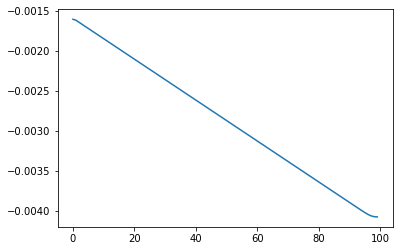

In [41]:
plt.plot(model_res['v0_dy'][:, -1])

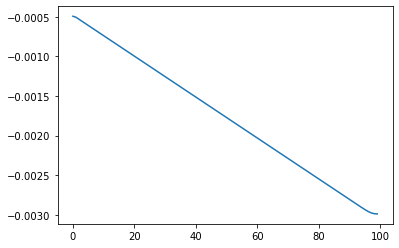

In [39]:
plt.plot(model_res['v0_dy'][:, -1])

In [20]:
ψ_ell = model_res['v0'][:, -1]
ψ_ell_right = model_res_right['v0'][:, -1]
dψ_ell = (ψ_ell_right-ψ_ell)/ell_step
r = -dψ_ell

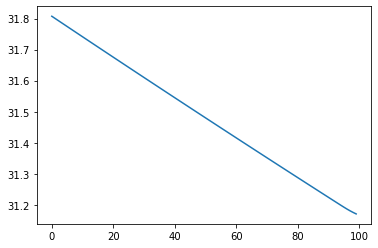

In [21]:
plt.plot(r)